In [16]:
%pip install biosynfoni

Note: you may need to restart the kernel to use updated packages.


In [17]:
import sys, os
from sys import argv

import numpy as np
import pandas as pd
import matplotlib as mpl

# matplotlib.use("Agg")
import matplotlib.pyplot as plt

# plt.ioff()
from rdkit import Chem

# sys.path.append('/Users/lucina-may/miniconda3/envs/jupyter/bin')
# print(sys.path)
import biosynfoni
from biosynfoni.inoutput import outfile_namer
from biosynfoni.subkeys import fpVersions, defaultVersion

# from utils.figuremaking import heatmap, annotate_heatmap

In [21]:
bsf_name_root = "full_1103"
block_state = "_lessblock"
bsf_name = f"{bsf_name_root}{block_state}"
# fingerprintfile_coco =  "1021_COCONUT_DB_rdk_aa_1018.bsf" # natural products
# fingerprintfile_zinc =  "1021_1017_my_synmols_aa_1018.bsf" # synthetic compounds

fingerprintfile_coco = "../../thesis/ml/coco/coconut_full1103lessblock.bsf"
fingerprintfile_zinc = "../../thesis/ml/zinc/zinc_full1103lessblock.bsf"

# fingerprintfile_coco =  "../../input/1128_COCONUT_DB_rdk_full_1103_noblock.bsf" # natural products
# fingerprintfile_zinc = "../../input/1129_1017_my_synmols_full_1103_noblock.bsf" #BLOCKED!

# fingerprintfile_coco = "1022_COCONUT_DB_rdk_leaf_noblock.bsf"
# fingerprintfile_zinc = "1022_1017_my_synmols_leaf_noblock.bsf"


if fpVersions[bsf_name_root]:
    substructure_names = fpVersions[bsf_name_root]

coco = np.loadtxt(fingerprintfile_coco, delimiter=",", dtype=int)
zinc = np.loadtxt(fingerprintfile_zinc, delimiter=",", dtype=int)
coco_name = fingerprintfile_coco.split("/")[-1].split(".")[0]
zinc_name = fingerprintfile_zinc.split("/")[-1].split(".")[0]

In [ ]:
# npcsfile = "0914_COCONUT_DB_rdk_npcs.tsv"
# arr = []
# with open(npcsfile, 'r') as f:
#    for line in f:
#        end_preds = ['', '', '']
#        preds = line.strip().split("\t")
#        for i in range(len(preds)):
#            end_preds[i] = preds[i]
#        arr.append(end_preds)
# arr[:10]
# arr = np.array(arr)
# len(arr)
# np.savetxt( "1022_COCONUT_DB_npcs.tsv",arr, fmt="%s", delimiter="\t")
npcs = np.loadtxt("../../input/1022_COCONUT_DB_rdk_npcs.tsv", dtype=str, delimiter="\t")
npcs
# select only pathways
pathways = npcs[:, 0]
unique_pathways = pd.DataFrame(pathways)
unique_pathways = unique_pathways[0].str.split(",", expand=True)
unique_pathways["biosynfoni"] = coco.tolist()
# unique_pathways['biosynfoni'] =unique_pathways["biosynfoni"].apply(lambda x: np.array(x))
# unique_pathways

### heatmap function def

In [ ]:
# use own style sheet
mpl.style.use("/Users/lucina-may/thesis/ml/biostylefoni.mplstyle")

In [ ]:
def heatmap(
    data: np.array,
    row_labels: list,
    col_labels: list,
    ax=None,
    cbar_kw=None,
    cbarlabel="",
    **kwargs,
):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    # cbar.ax.set_yticks([]) #remove tick labels
    cbar.outline.set_visible(False)

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels, size=6)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels, size=6)
    # ax.set_yticks([])

    # Let the horizontal axes labeling appear on bottom (default)
    ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)
    ax.tick_params(pad=0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1] + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0] + 1) - 0.5, minor=True)
    ax.grid(which="minor", color="w", linestyle="-", linewidth=1, alpha=1.0)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(
    im,
    data=None,
    valfmt="{x:.2f}",
    textcolors=("black", "white"),
    threshold=None,
    **textkw,
):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max()) / 2.0

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center", verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [ ]:
def fp_stats(fp_arr: np.array, set_name: str) -> np.array:
    mean_fp = fp_arr.mean(axis=0)
    std_fp = fp_arr.std(axis=0)
    outfile = f"{outfile_namer('fp_avg', set_name)}.csv"
    with open(outfile, "w") as f:
        f.write("\t".join([str(x) for x in mean_fp]))
        f.write("\n")
        f.write("\t".join([str(x) for x in std_fp]))
    return mean_fp


def fp_means_plots(fp_mean_arr1, fp_mean_arr2, filename):
    plt.figure()
    print("making plot")

    joined = np.array([fp_mean_arr1, fp_mean_arr2])
    both = np.transpose(np.array([fp_mean_arr1, fp_mean_arr2]))

    plt.stairs(fp_mean_arr1, color="green", label="natural products")
    plt.stairs(fp_mean_arr2, color="grey", label="synthetic compounds")

    plt.xlabel("substructure no.")  # , fontsize=20)
    plt.ylabel("mean fp count")  # , fontsize=20)
    plt.title(
        "mean fp count per substructure for natural products and synthetic compounds"
    )  # , fontsize=20)
    print("saving plot")
    plt.legend()
    plt.savefig(filename)
    plt.close()
    return None


def fp_plots(fp_arr, bsf_name):
    plt.ioff()
    plt.figure().set_figwidth(15)
    print("making plot")
    plt.violinplot(dataset=fp_arr, showmeans=True)
    print("saving plot")
    plt.savefig(f"fp_avg_{bsf_name}.svg")
    plt.close()
    return None


def heatmap_array(
    fp_arr: np.array,
    max_height: int = 30,
    percentages=False,
    accumulative=True,
    end_accumulative=False,
):
    heat_array = np.zeros((max_height, fp_arr.shape[1]))
    for i in range(max_height):
        if accumulative:
            countrow = np.count_nonzero(fp_arr > i, axis=0)
        else:
            if end_accumulative and i == max_height - 1:
                # for last height, count all remaining values
                countrow = np.count_nonzero(fp_arr > i, axis=0)
            else:
                countrow = np.count_nonzero((fp_arr == i + 1), axis=0)
        heat_array[max_height - 1 - i] = countrow

    if percentages:
        heat_array = heat_array / fp_arr.shape[0] * 100
    return heat_array.astype(int)


def fp_heatmap(
    fp_arr: np.array,
    filename: str,
    subsnames: list = [],
    bsfname: str = "",
    size: tuple[int] = (10, 6),
    percentages: bool = False,
    annotate: bool = False,
    scheme: str = "Purples",
    title: str = "Representative substructure count for compound collection",
    top_acc_array=None,
):
    cbarlab = "number of compounds"
    if percentages:
        cbarlab = "percentage of compounds"

    print("saving heatmap")
    height = fp_arr.shape[0]
    fig, ax = plt.subplots(figsize=size, dpi=500)
    if not subsnames:
        subsnames = [f"subs{i}" for i in range(1, fp_arr.shape[1] + 1)]

    yaxlabels = [(height + 1 - i) for i in range(1, height + 1)]
    if top_acc_array is not None:
        yaxlabels[0] = f"≥{height}"
        im2, cbar2 = heatmap(
            top_acc_array,
            # ['>11']+[(height+1-i) for i in range(1, height + 1)],
            yaxlabels,
            subsnames,
            ax=ax,
            cmap="Greys",
            # cmap = "PiYG",
            cbarlabel=f"{cbarlab}, accumulative",
            cbar_kw={"drawedges": False, "shrink": 0.5, "pad": 0.05, "aspect": 10},
        )

    im, cbar = heatmap(
        fp_arr,
        # [(height+1-i) for i in range(1, height + 1)],
        yaxlabels,
        subsnames,
        ax=ax,
        cmap=scheme,
        # cmap = "PiYG",
        cbarlabel=cbarlab,
        cbar_kw={"drawedges": False, "shrink": 0.5, "pad": 0.05, "aspect": 10},
    )

    # texts = annotate_heatmap(im, valfmt="{x:.1f}")
    if annotate:
        texts = annotate_heatmap(im, valfmt="{x:.0f}", size=7)
    # plt.figure(figsize=(10,6))
    ax.set_xlabel("substructure")
    ax.set_ylabel("counts", labelpad=10)
    ax.set_title(title, loc="center", pad=20)
    fig.tight_layout()
    # plt.show()
    # for filename, using collection name is nice
    plt.savefig(f"{outfile_namer(filename, bsfname)}_heatmap.png")
    return None

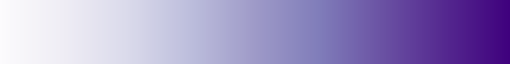

In [27]:
def custom_cmap(default_cmap, last_color=None, first_color=None):
    cmap = mpl.colormaps[default_cmap]
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # force the first color entry to be grey
    if first_color:
        cmaplist[0] = first_color
    if last_color:
        cmaplist[-1] = last_color

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list("Custom cmap", cmaplist, cmap.N)
    return cmap


def over_under_divide(array: np.array, limit: int = 10):
    full = heatmap_array(
        array,
        max_height=limit + 1,
        percentages=True,
        accumulative=False,
        end_accumulative=True,
    )
    under, over = full.astype(float).copy(), full.astype(float).copy()
    under[0] = np.nan
    over[1:] = np.nan
    return under, over


custom = custom_cmap("Purples", last_color=(1.0, 1.0, 0.95, 0))
custom

### running

In [ ]:
zinc

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 1]])

In [25]:
chebi = np.loadtxt(
    "../../thesis/ml/chebi/chebi_full1103lessblock.csv", delimiter=",", dtype=int
)

In [ ]:
len(zinc)

3019371

saving heatmap
saving heatmap
saving heatmap


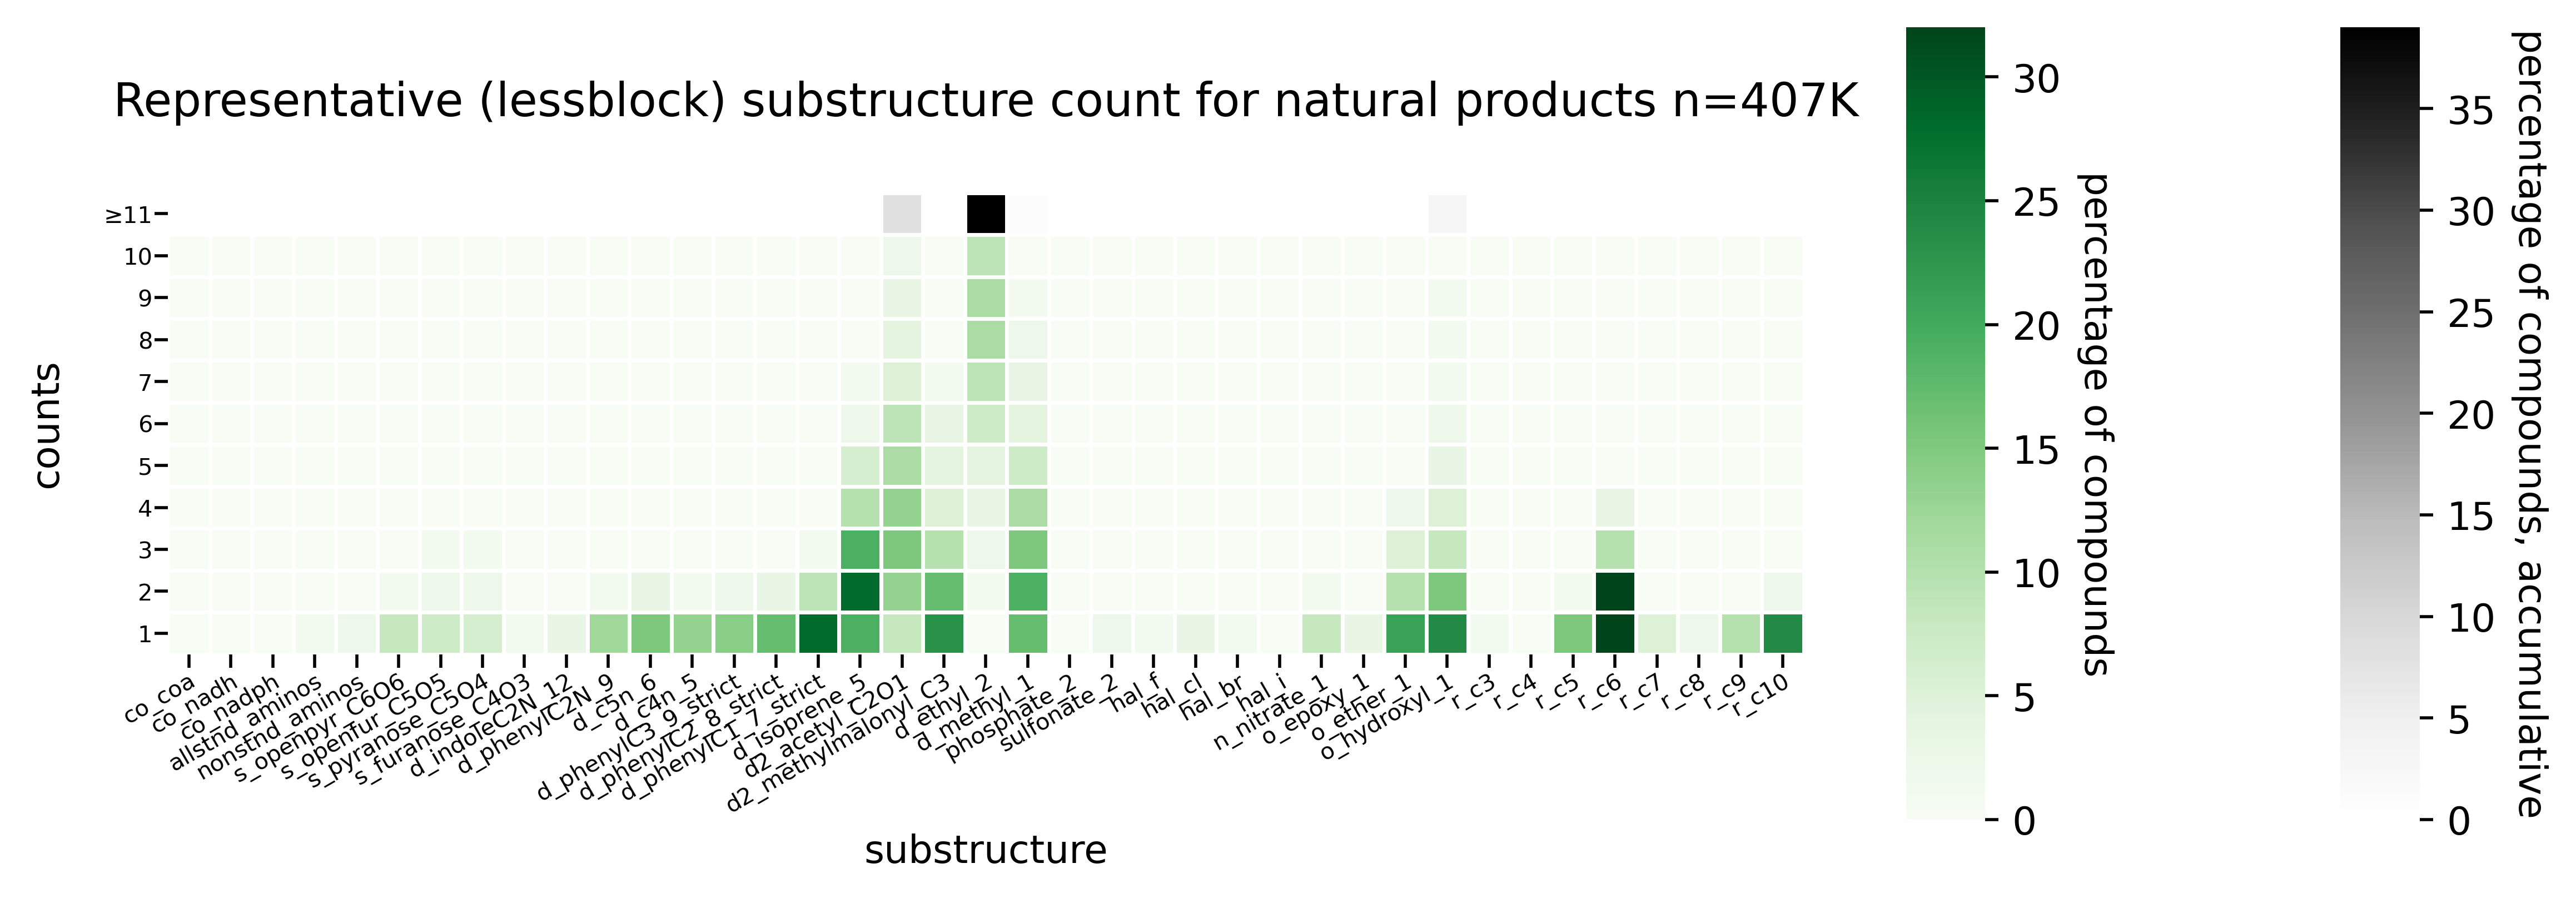

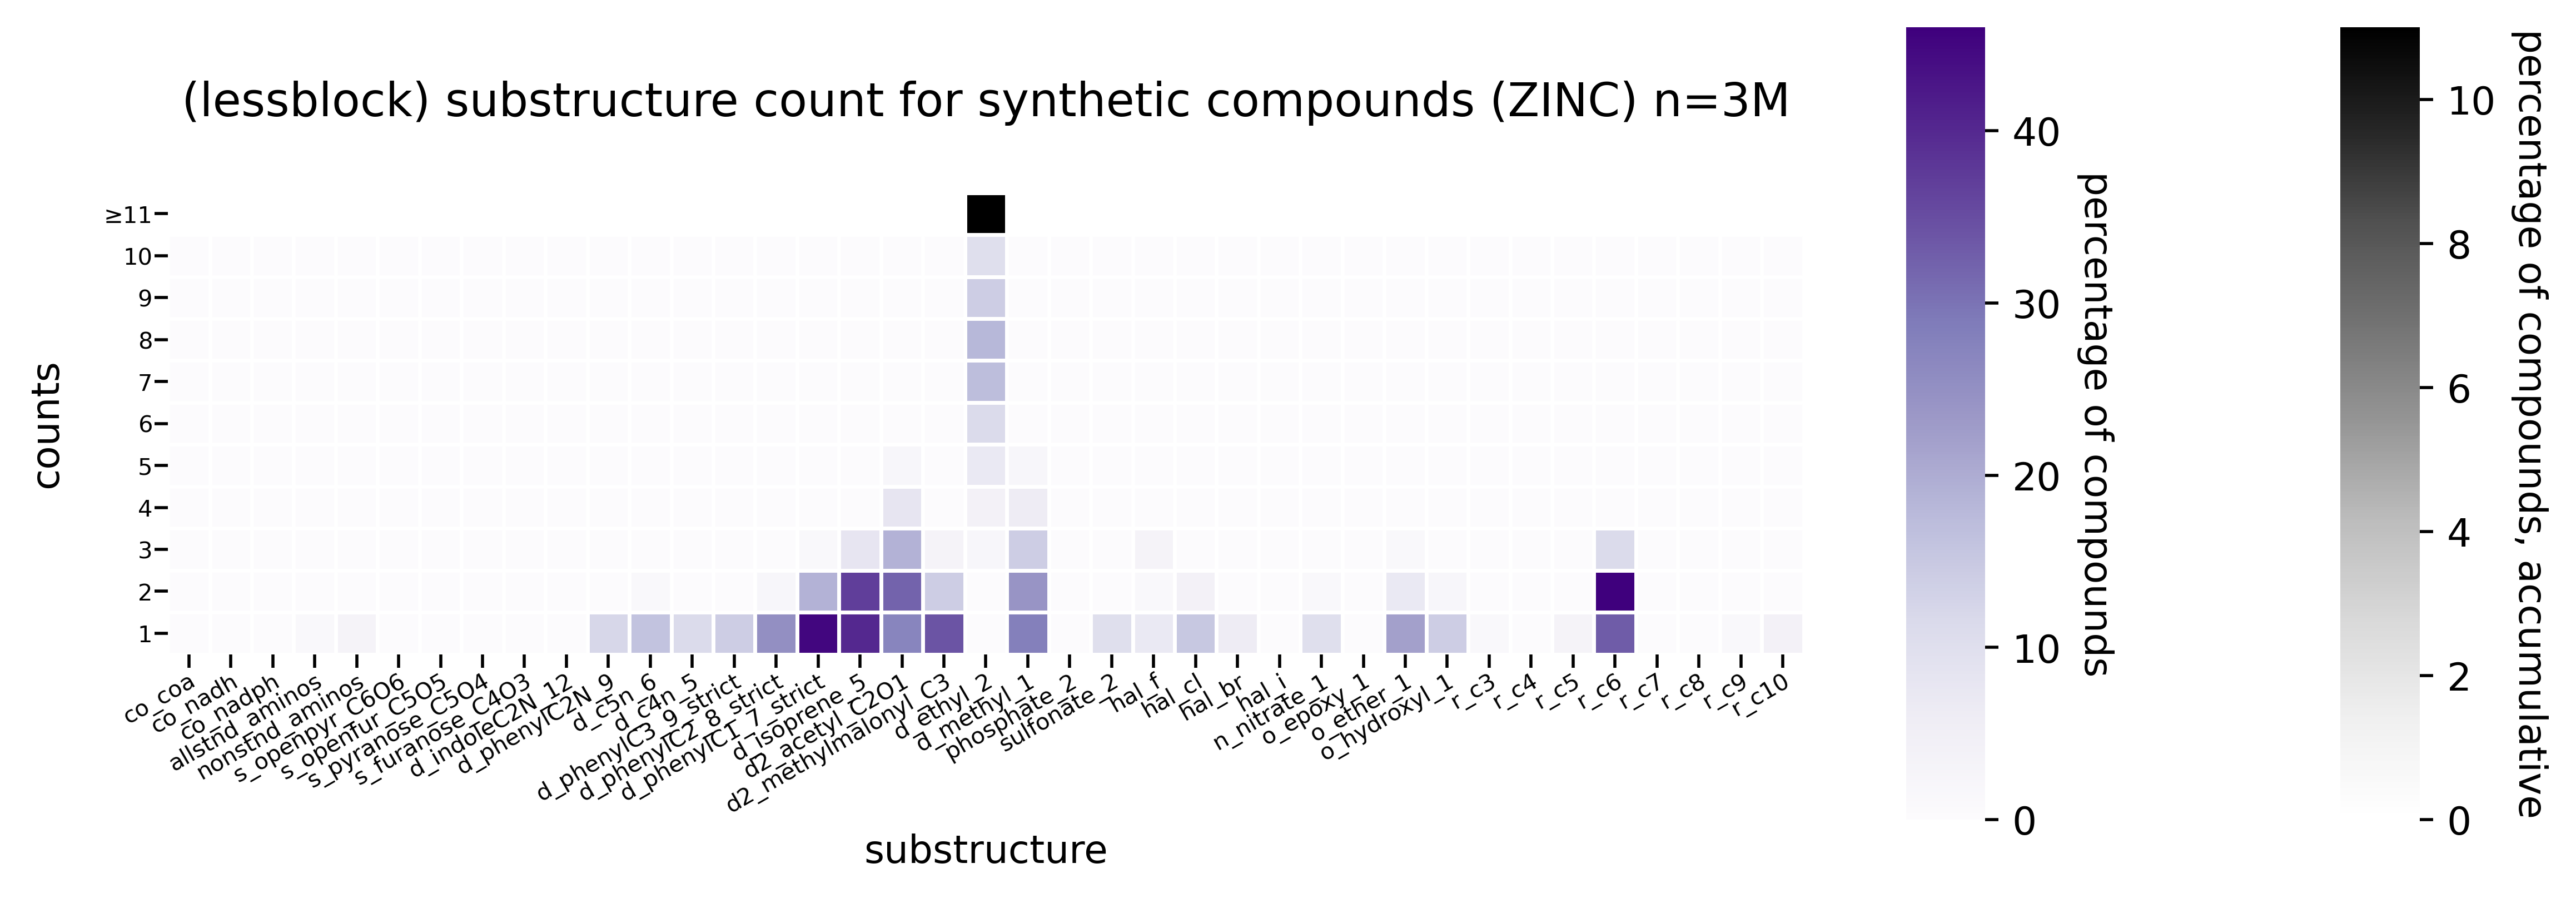

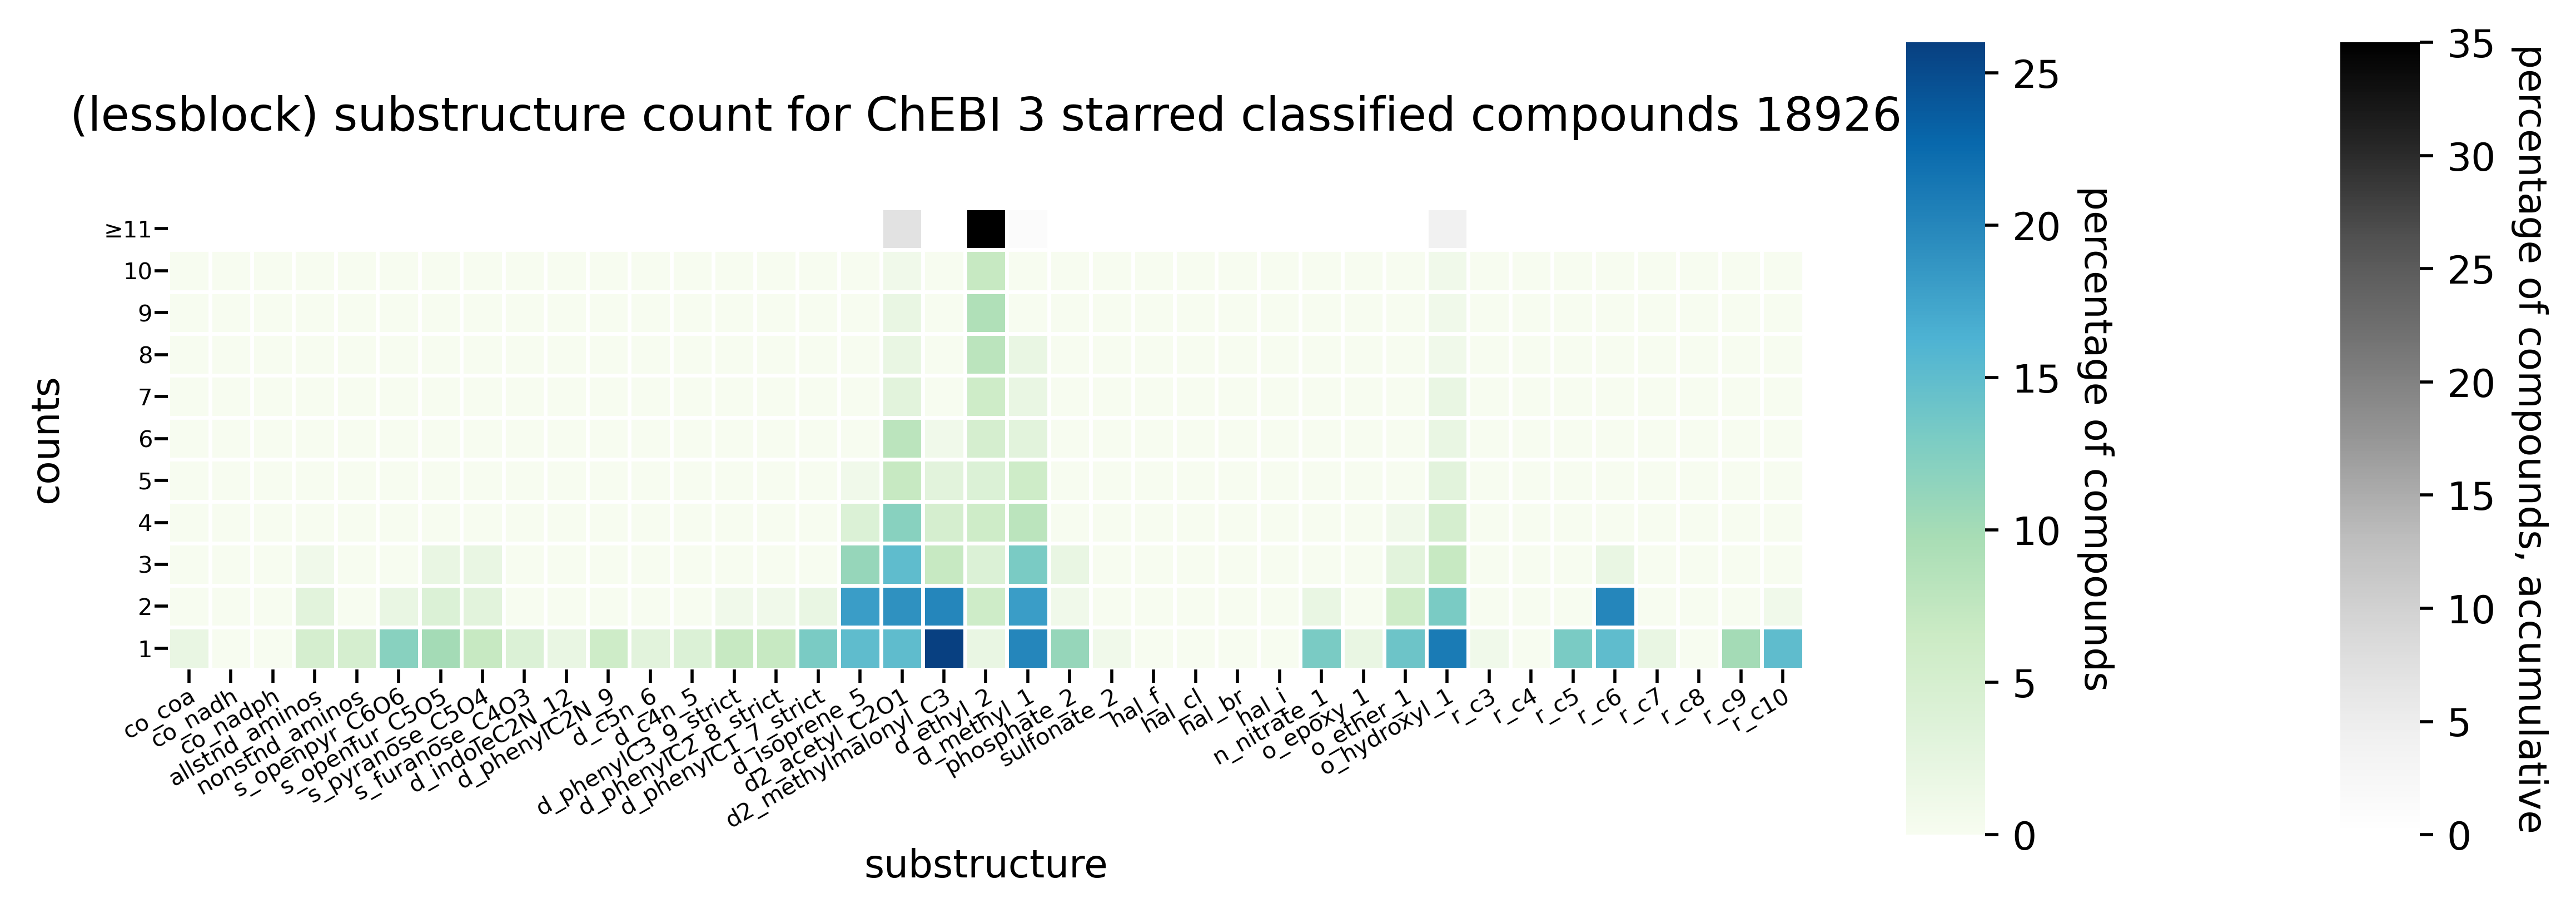

In [26]:
percentages = True
annotate = False
relay_subs = True
width = 10

coco_under_10, coco_over_10 = over_under_divide(coco, limit=10)
zinc_under_10, zinc_over_10 = over_under_divide(zinc, limit=10)
chebi_under_10, chebi_over_10 = over_under_divide(chebi, limit=10)

fp_heatmap(
    # heatmap_array(coco, max_height=15, percentages=percentages, accumulative=False, end_accumulative=True),
    coco_under_10,
    coco_name,
    subsnames=(substructure_names if relay_subs else []),
    bsfname="",
    size=(width, 6),
    percentages=percentages,
    annotate=annotate,
    scheme="Greens",
    title=f"Representative ({block_state.strip('_')}) substructure count for natural products n=407K",
    top_acc_array=coco_over_10,  # top accumulative array)
)

fp_heatmap(
    # heatmap_array(zinc, max_height=15, percentages=percentages, accumulative = False, end_accumulative=True),
    zinc_under_10,
    zinc_name,
    subsnames=(substructure_names if relay_subs else []),
    bsfname="",
    size=(width, 6),
    percentages=percentages,
    annotate=annotate,
    scheme="Purples",
    title=f"({block_state.strip('_')}) substructure count for synthetic compounds (ZINC) n=3M",
    top_acc_array=zinc_over_10,
)

fp_heatmap(
    chebi_under_10,
    "chebi",
    subsnames=(substructure_names if relay_subs else []),
    bsfname="",
    size=(width, 6),
    percentages=percentages,
    annotate=annotate,
    scheme="GnBu",
    title=f"({block_state.strip('_')}) substructure count for ChEBI 3 starred classified compounds {len(chebi)}",
    top_acc_array=chebi_over_10,
)

In [118]:
version = "full1103lessblock"
np.savetxt(f"{version}.tsv", substructure_names, fmt="%s", delimiter="\t")

saving heatmap
saving heatmap
saving heatmap
saving heatmap
saving heatmap
saving heatmap
saving heatmap
saving heatmap


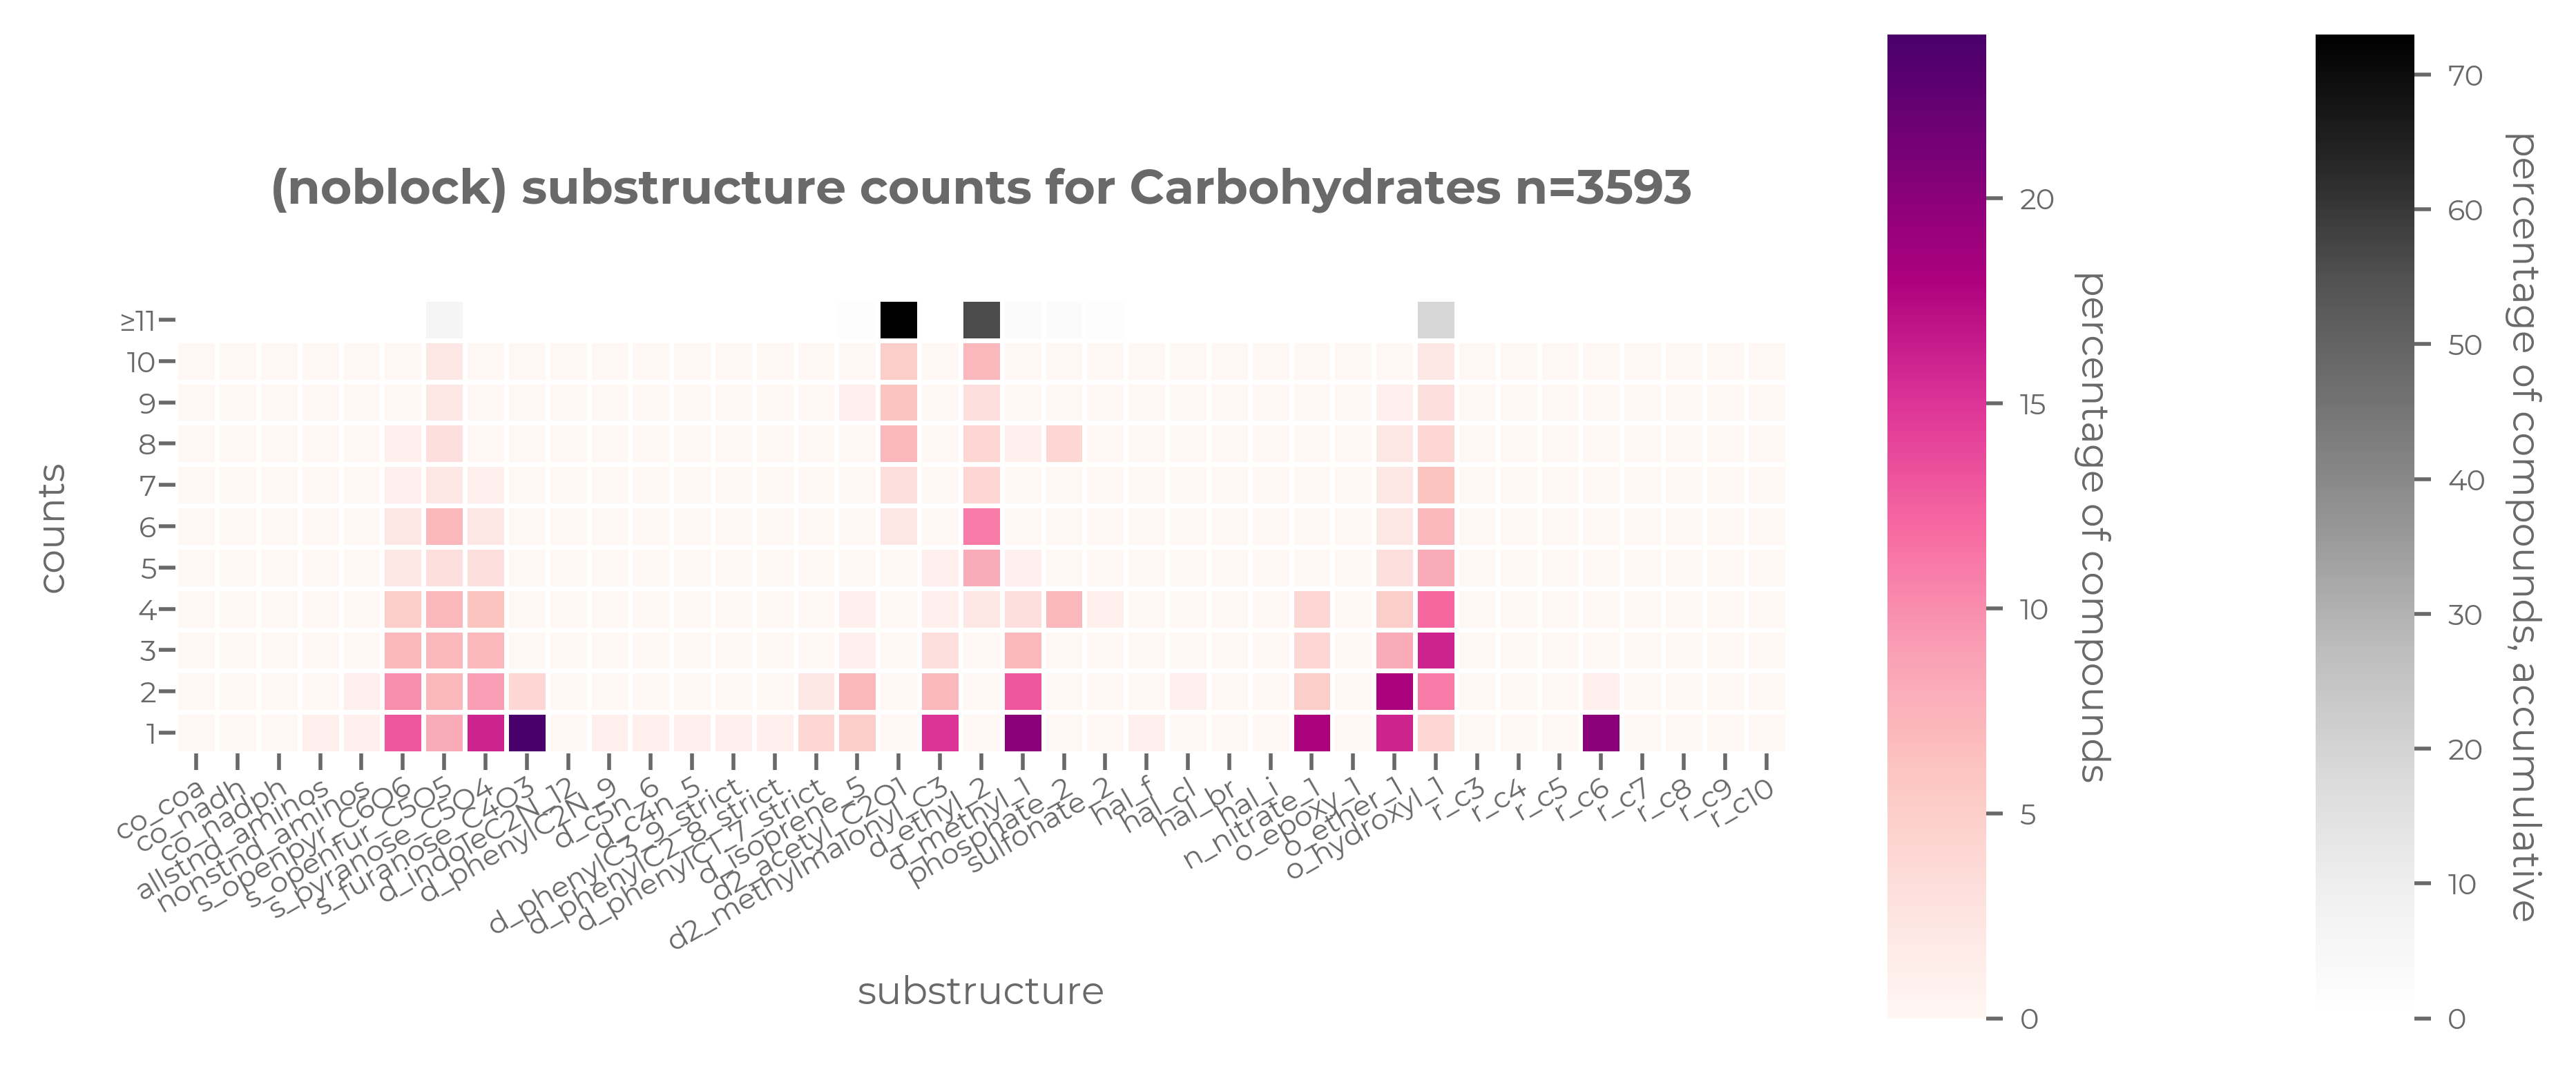

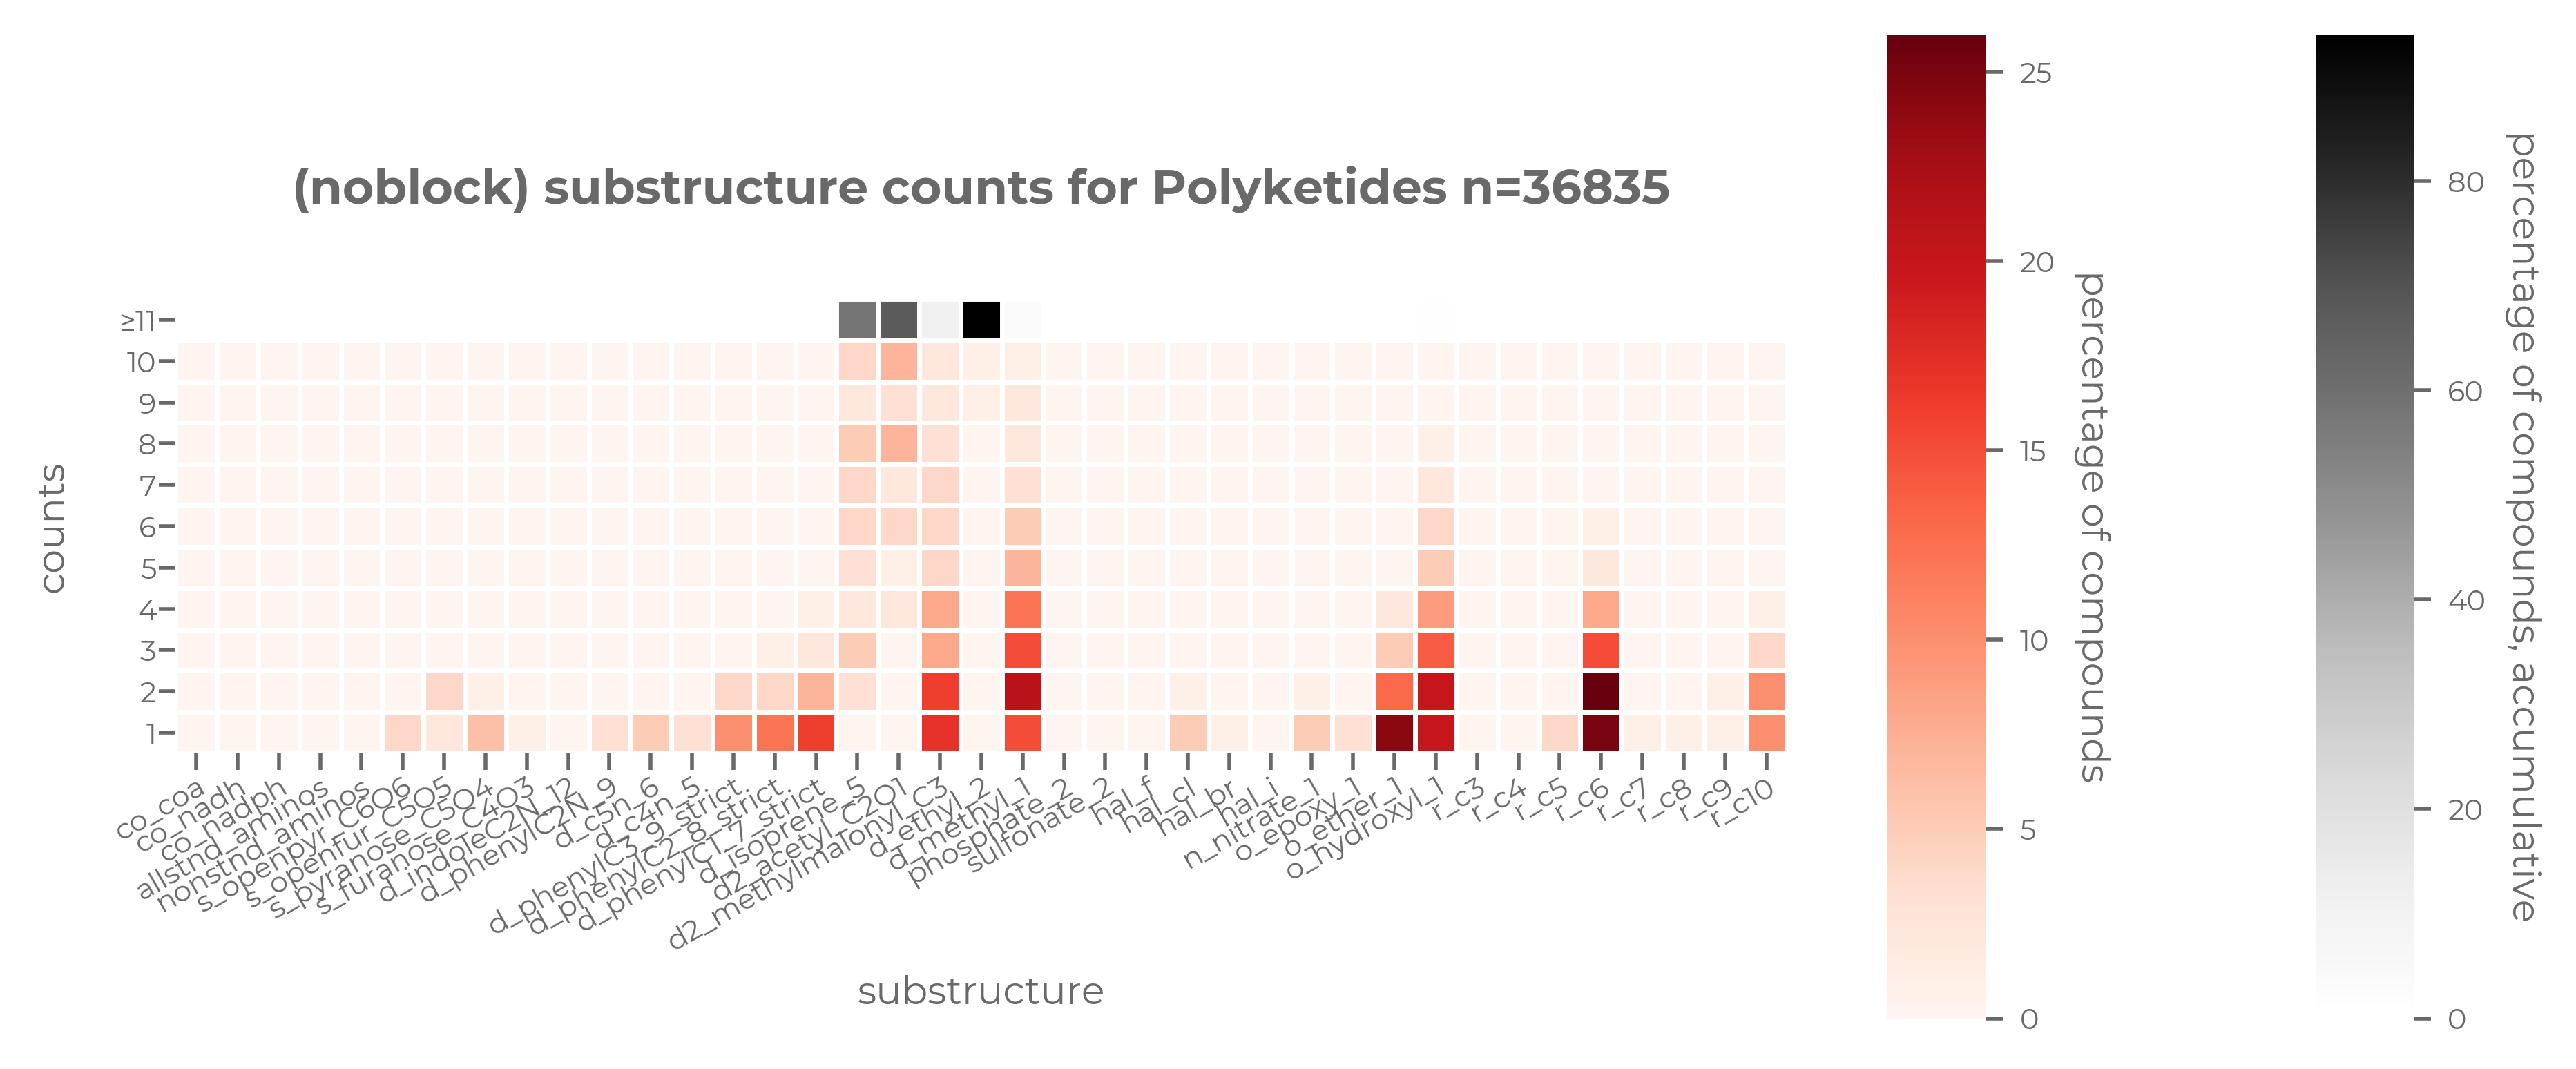

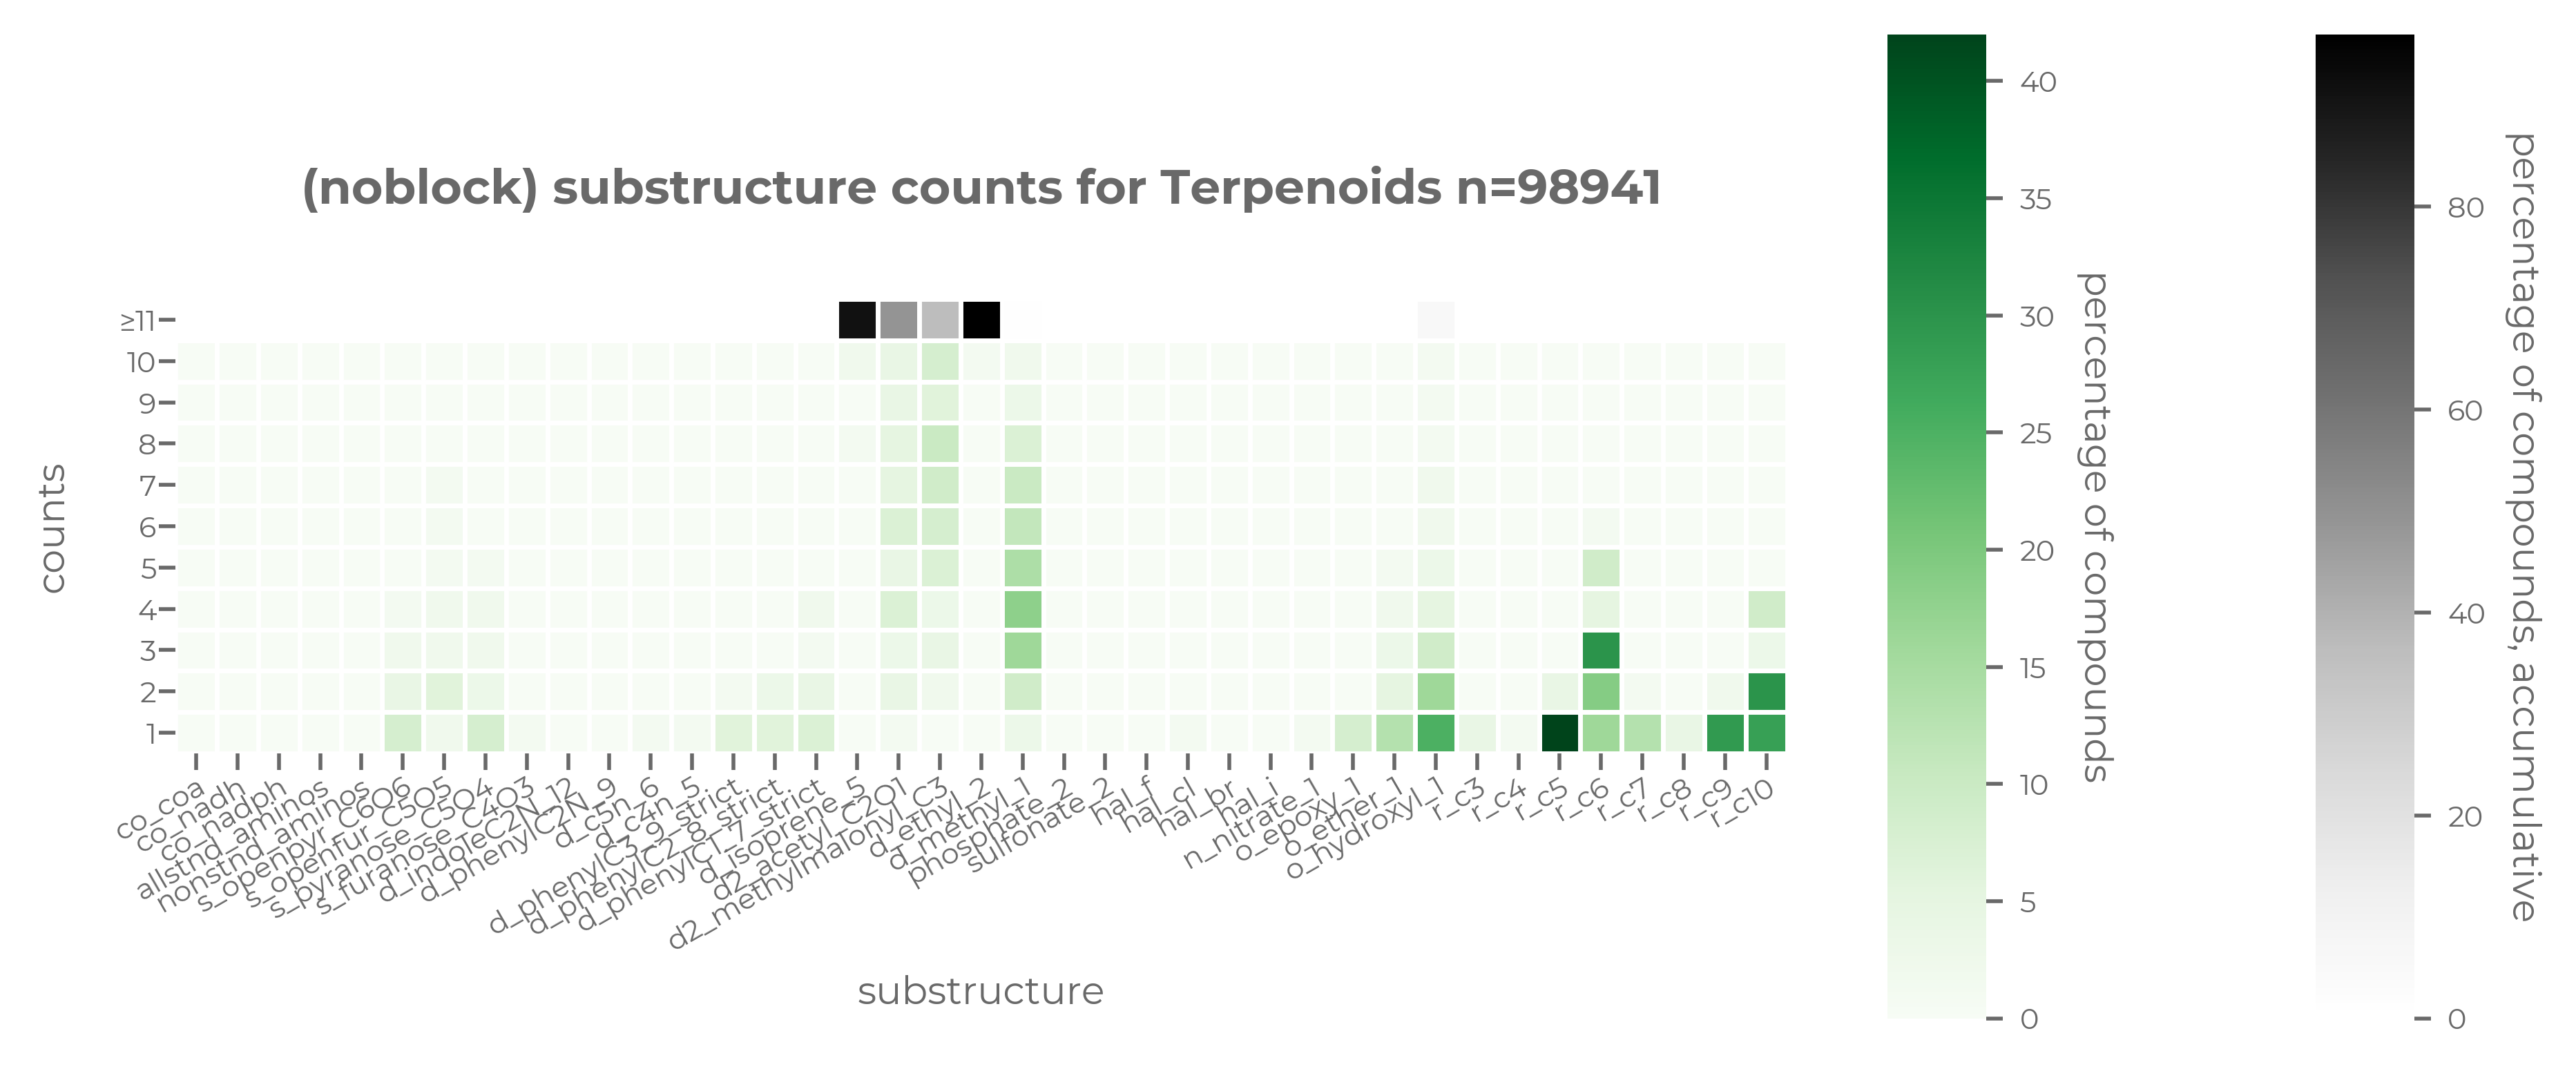

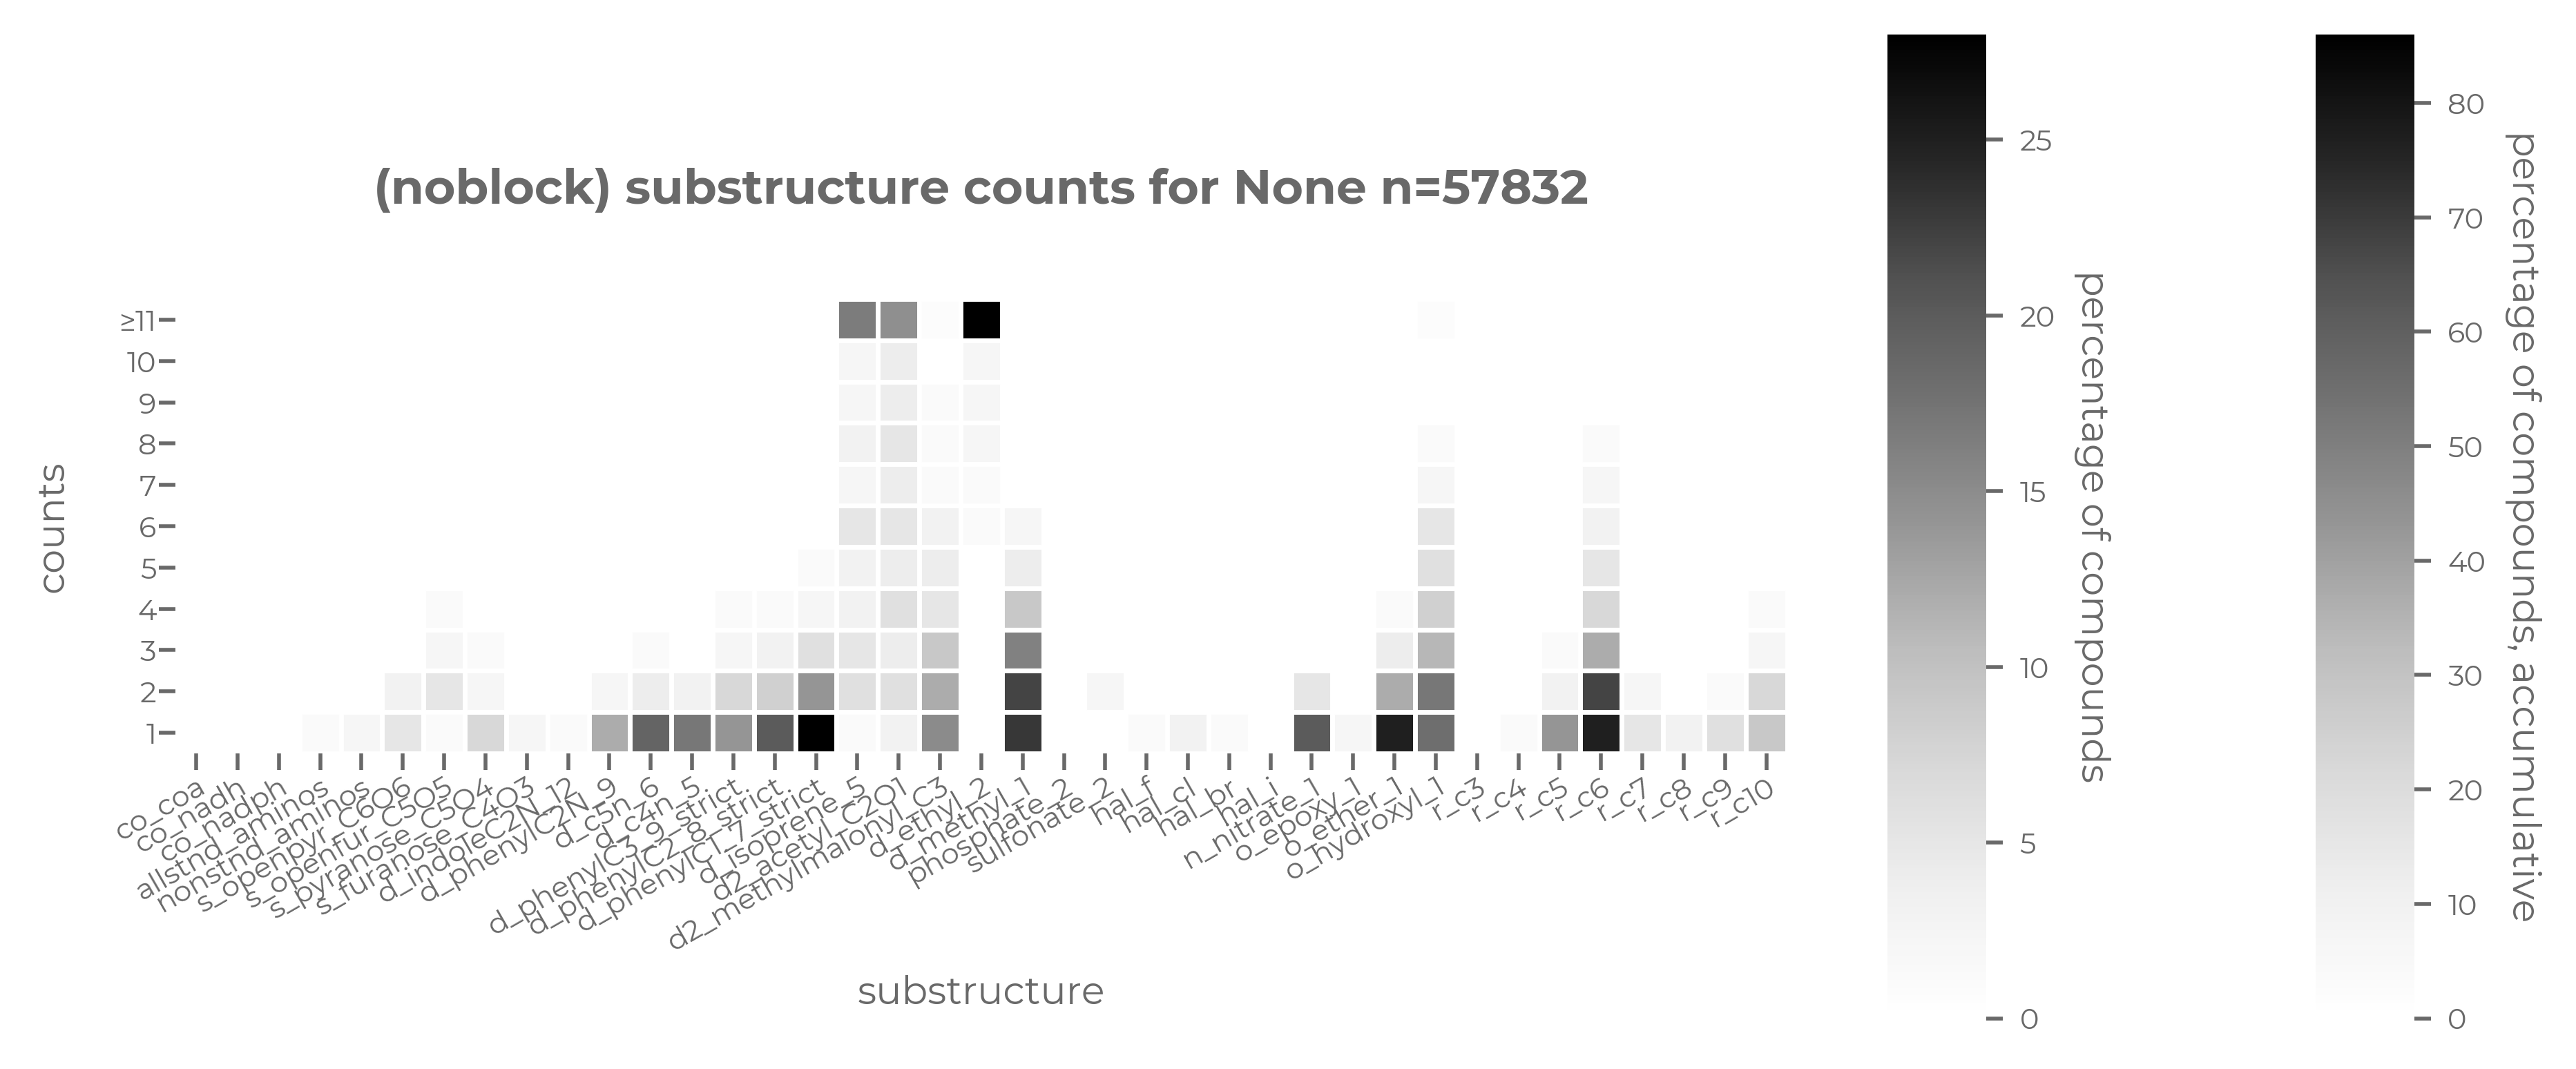

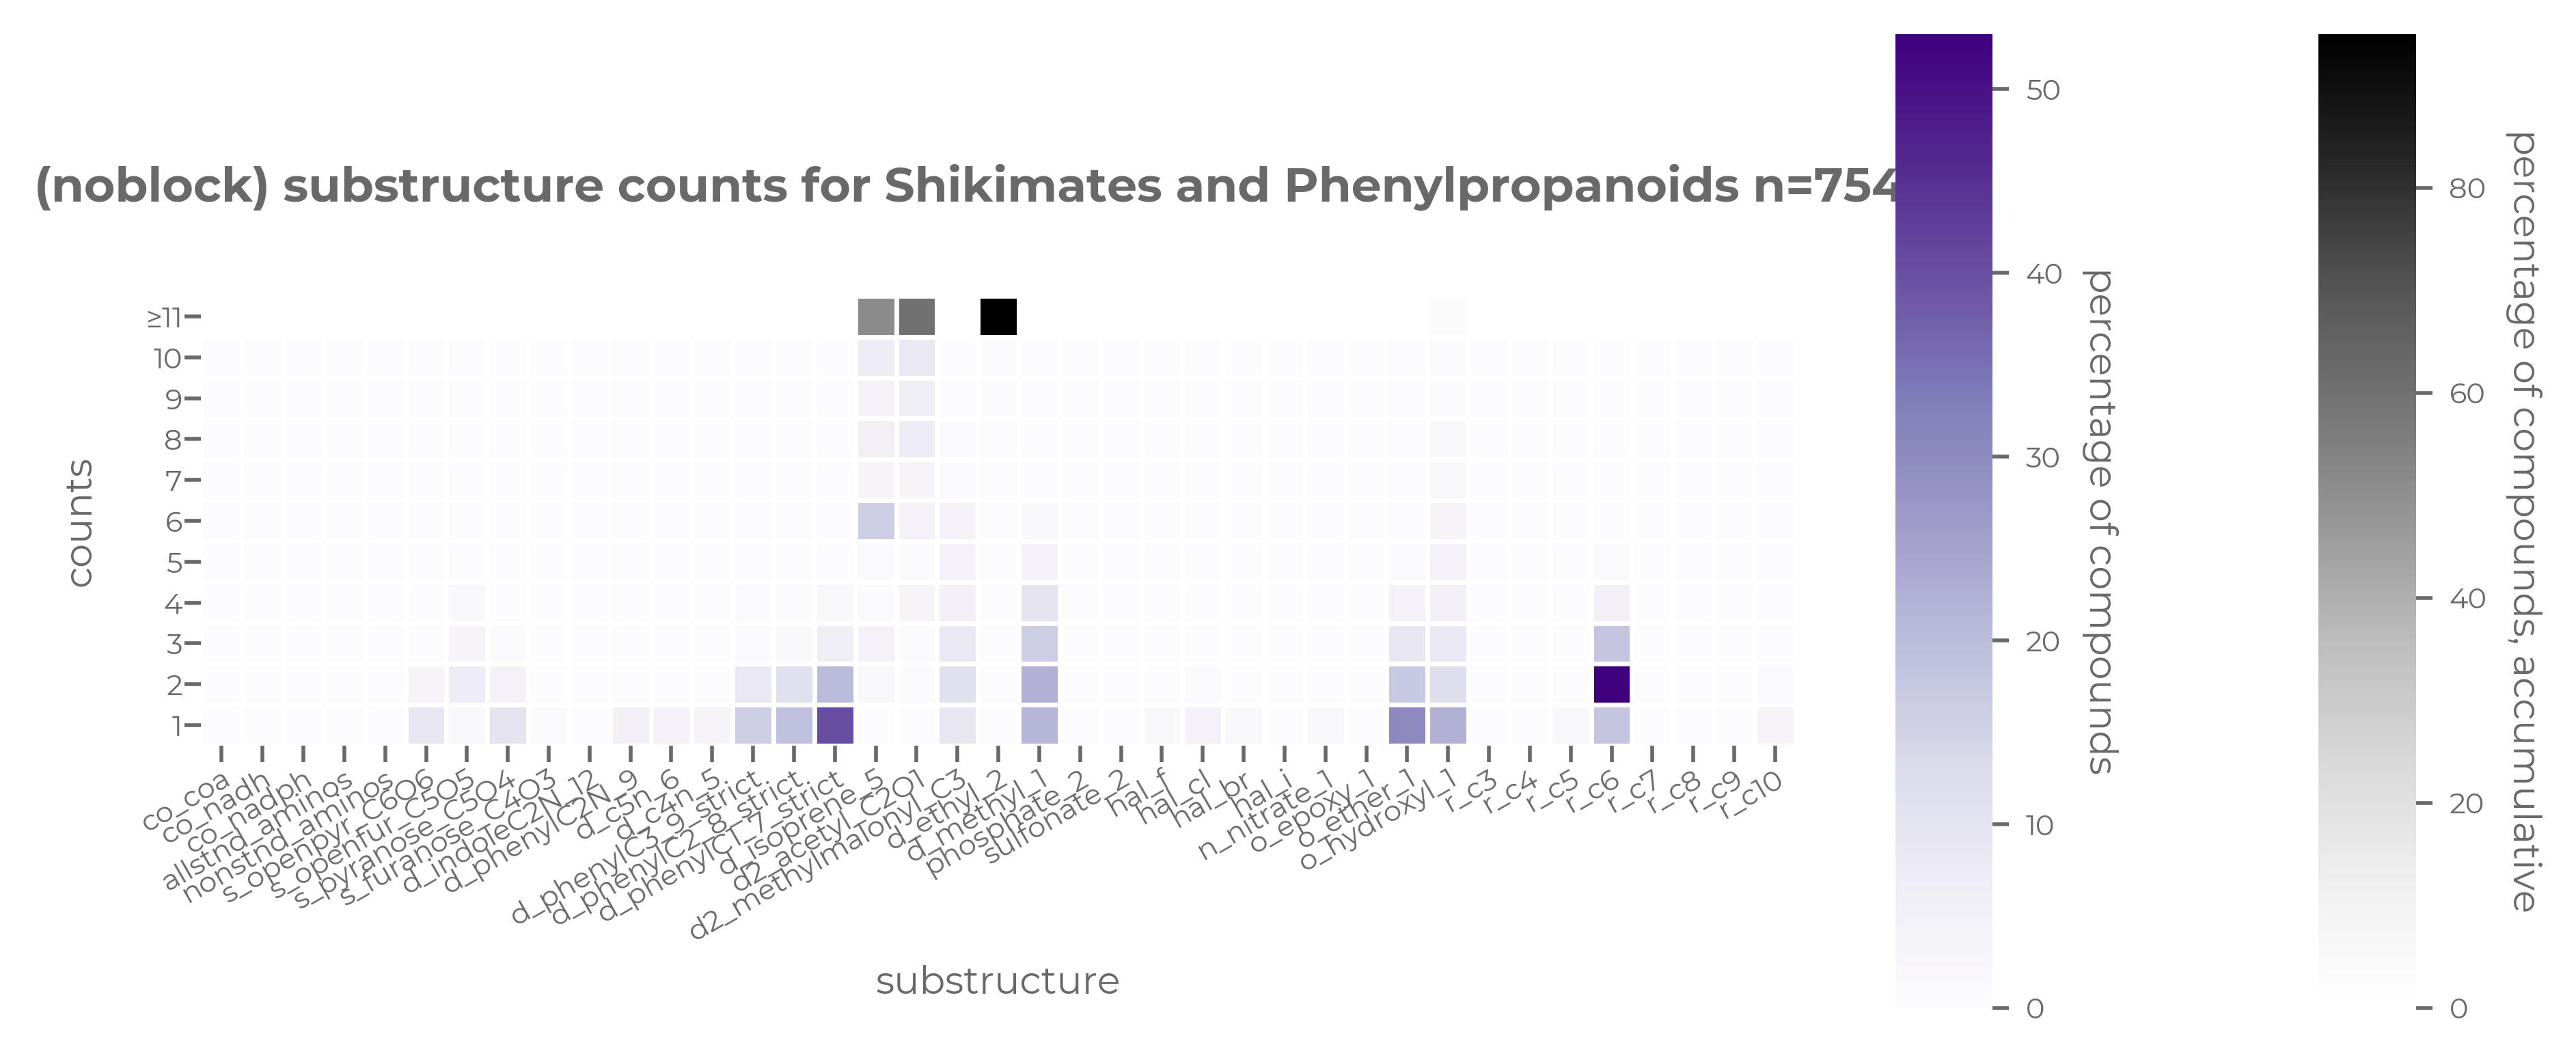

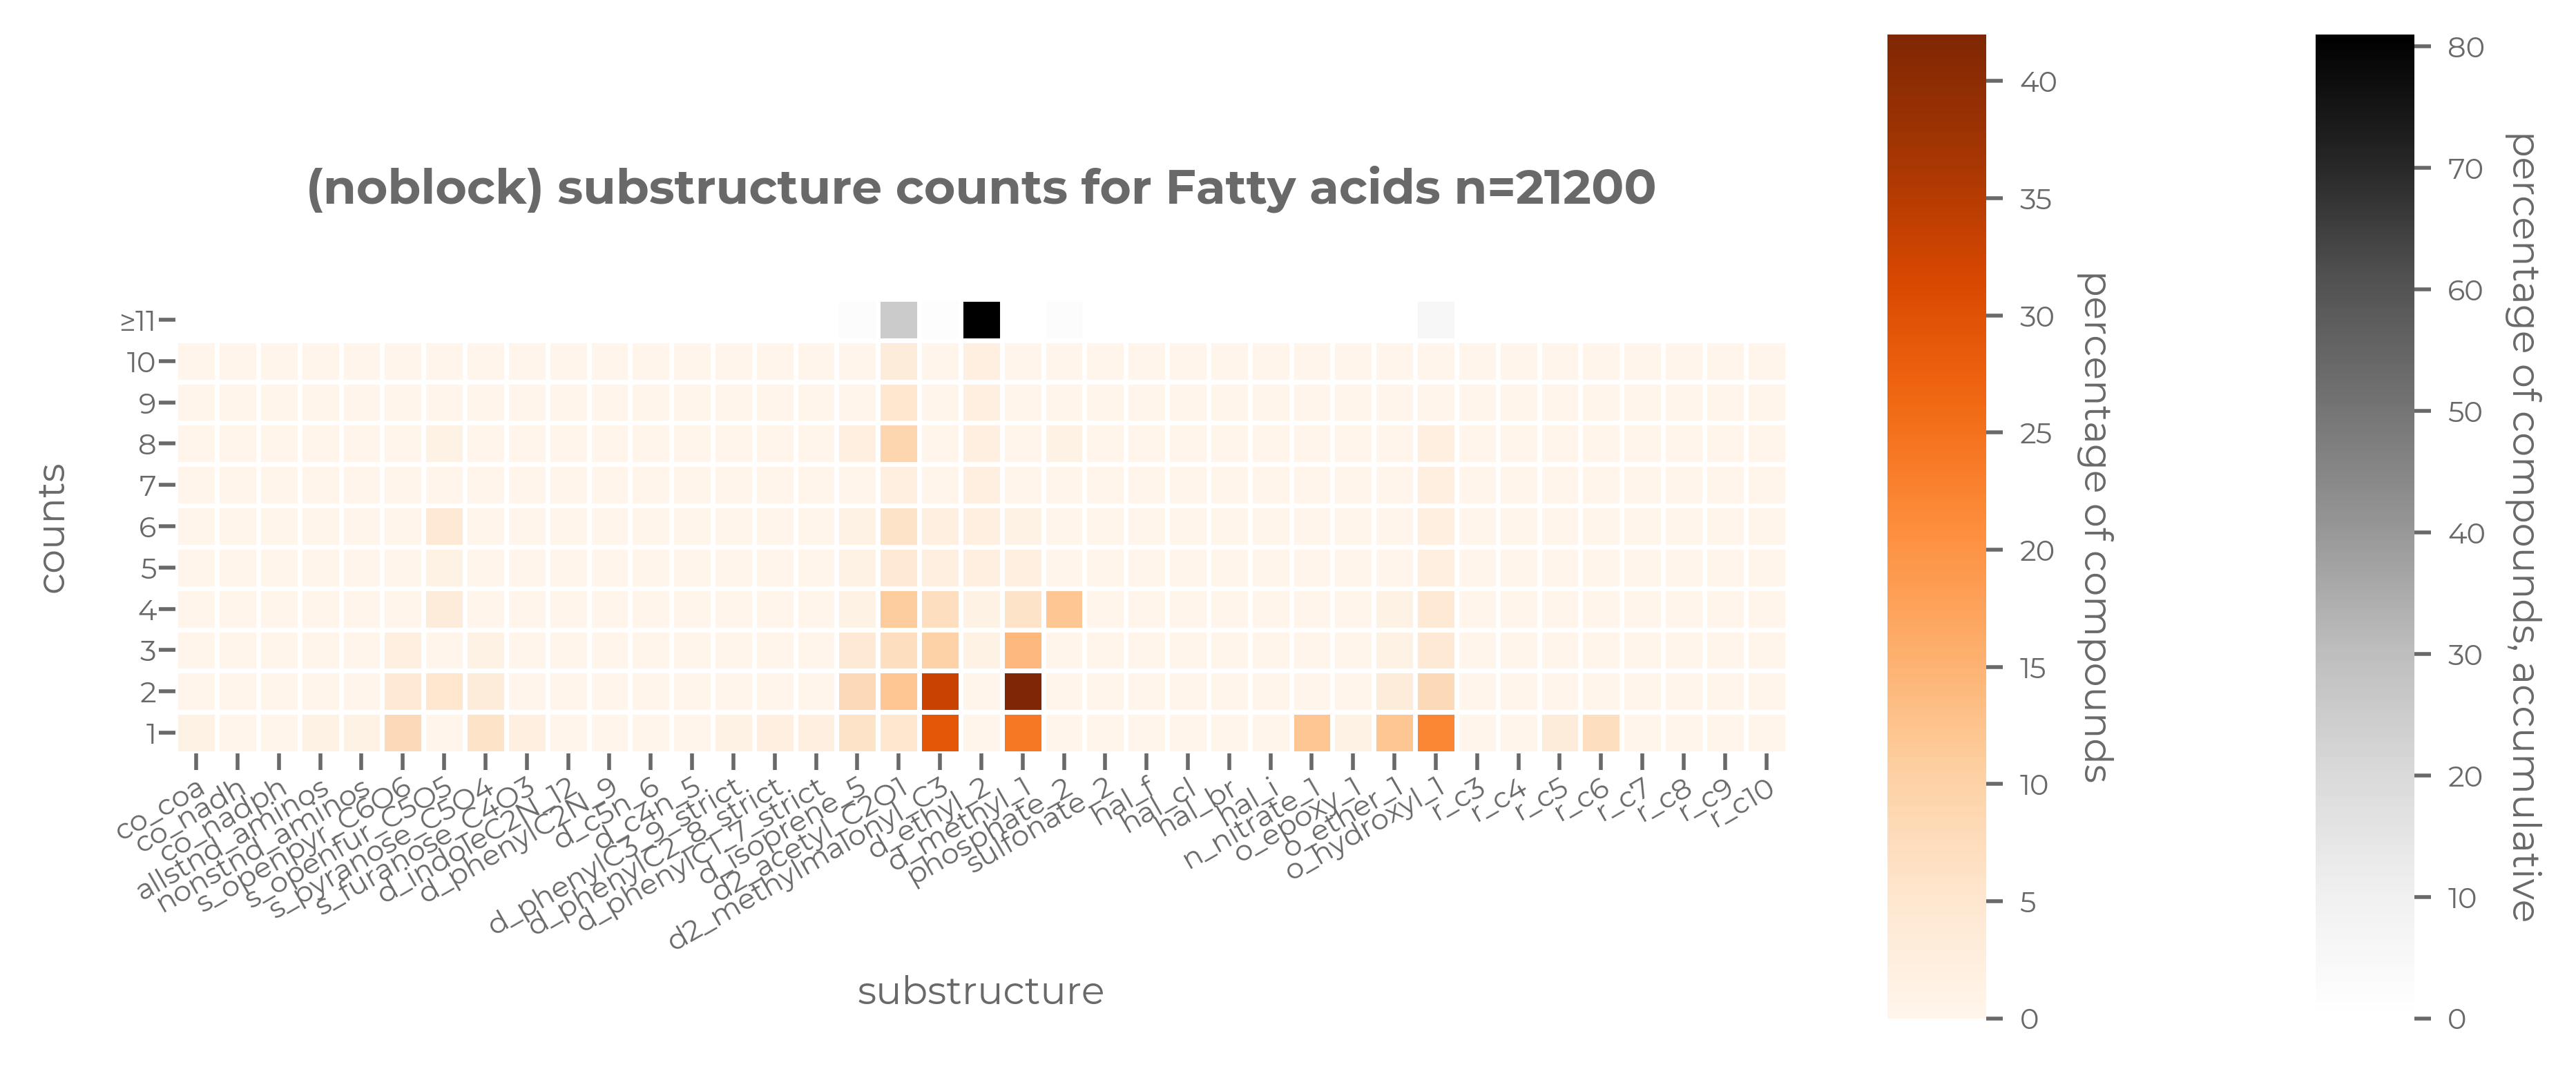

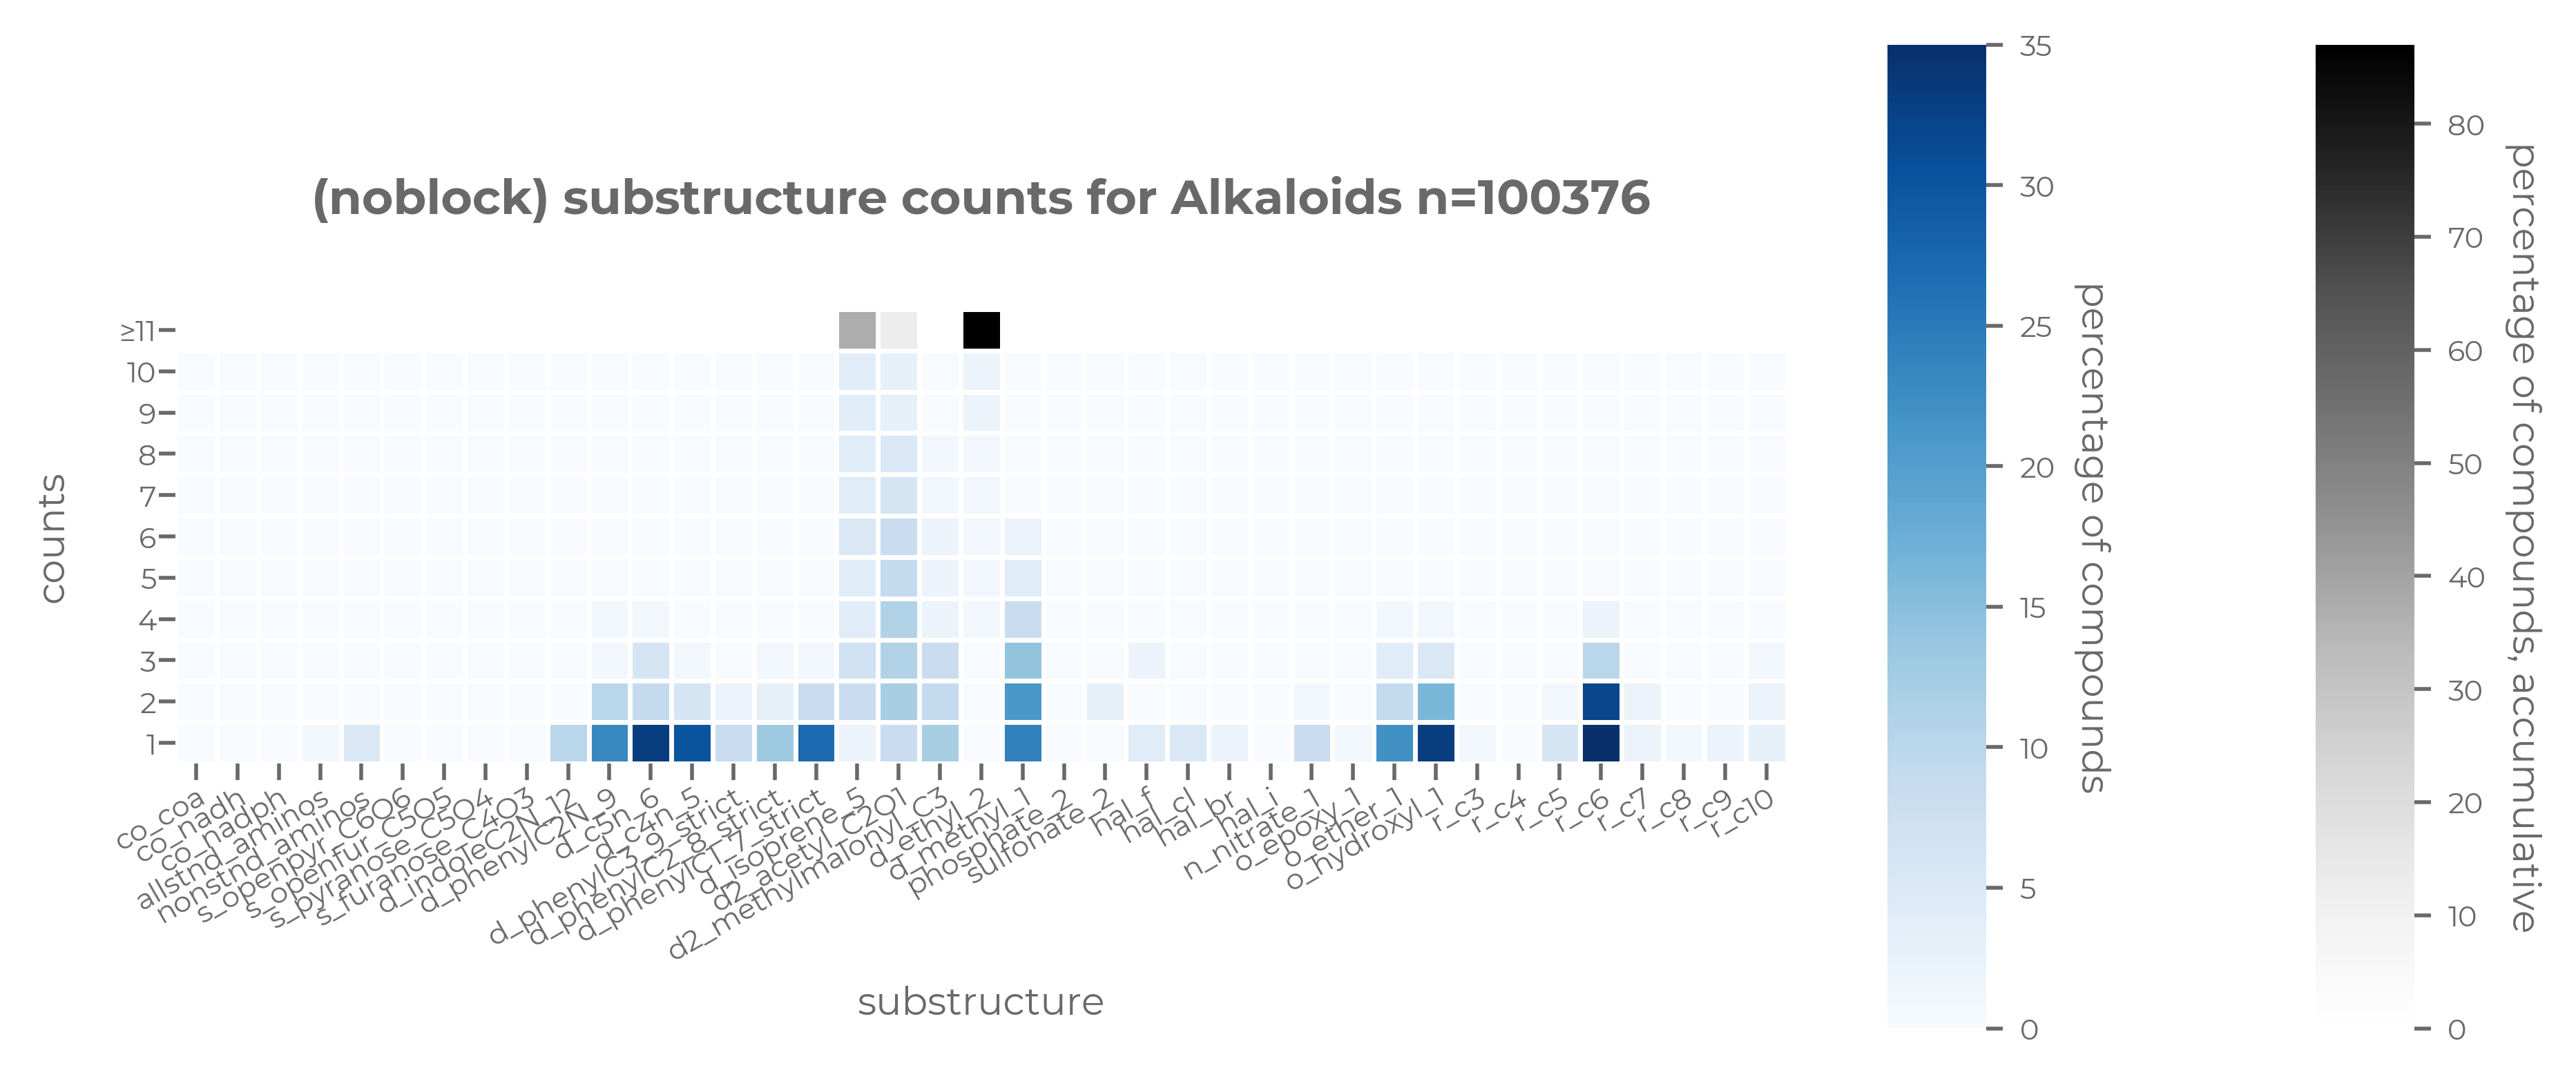

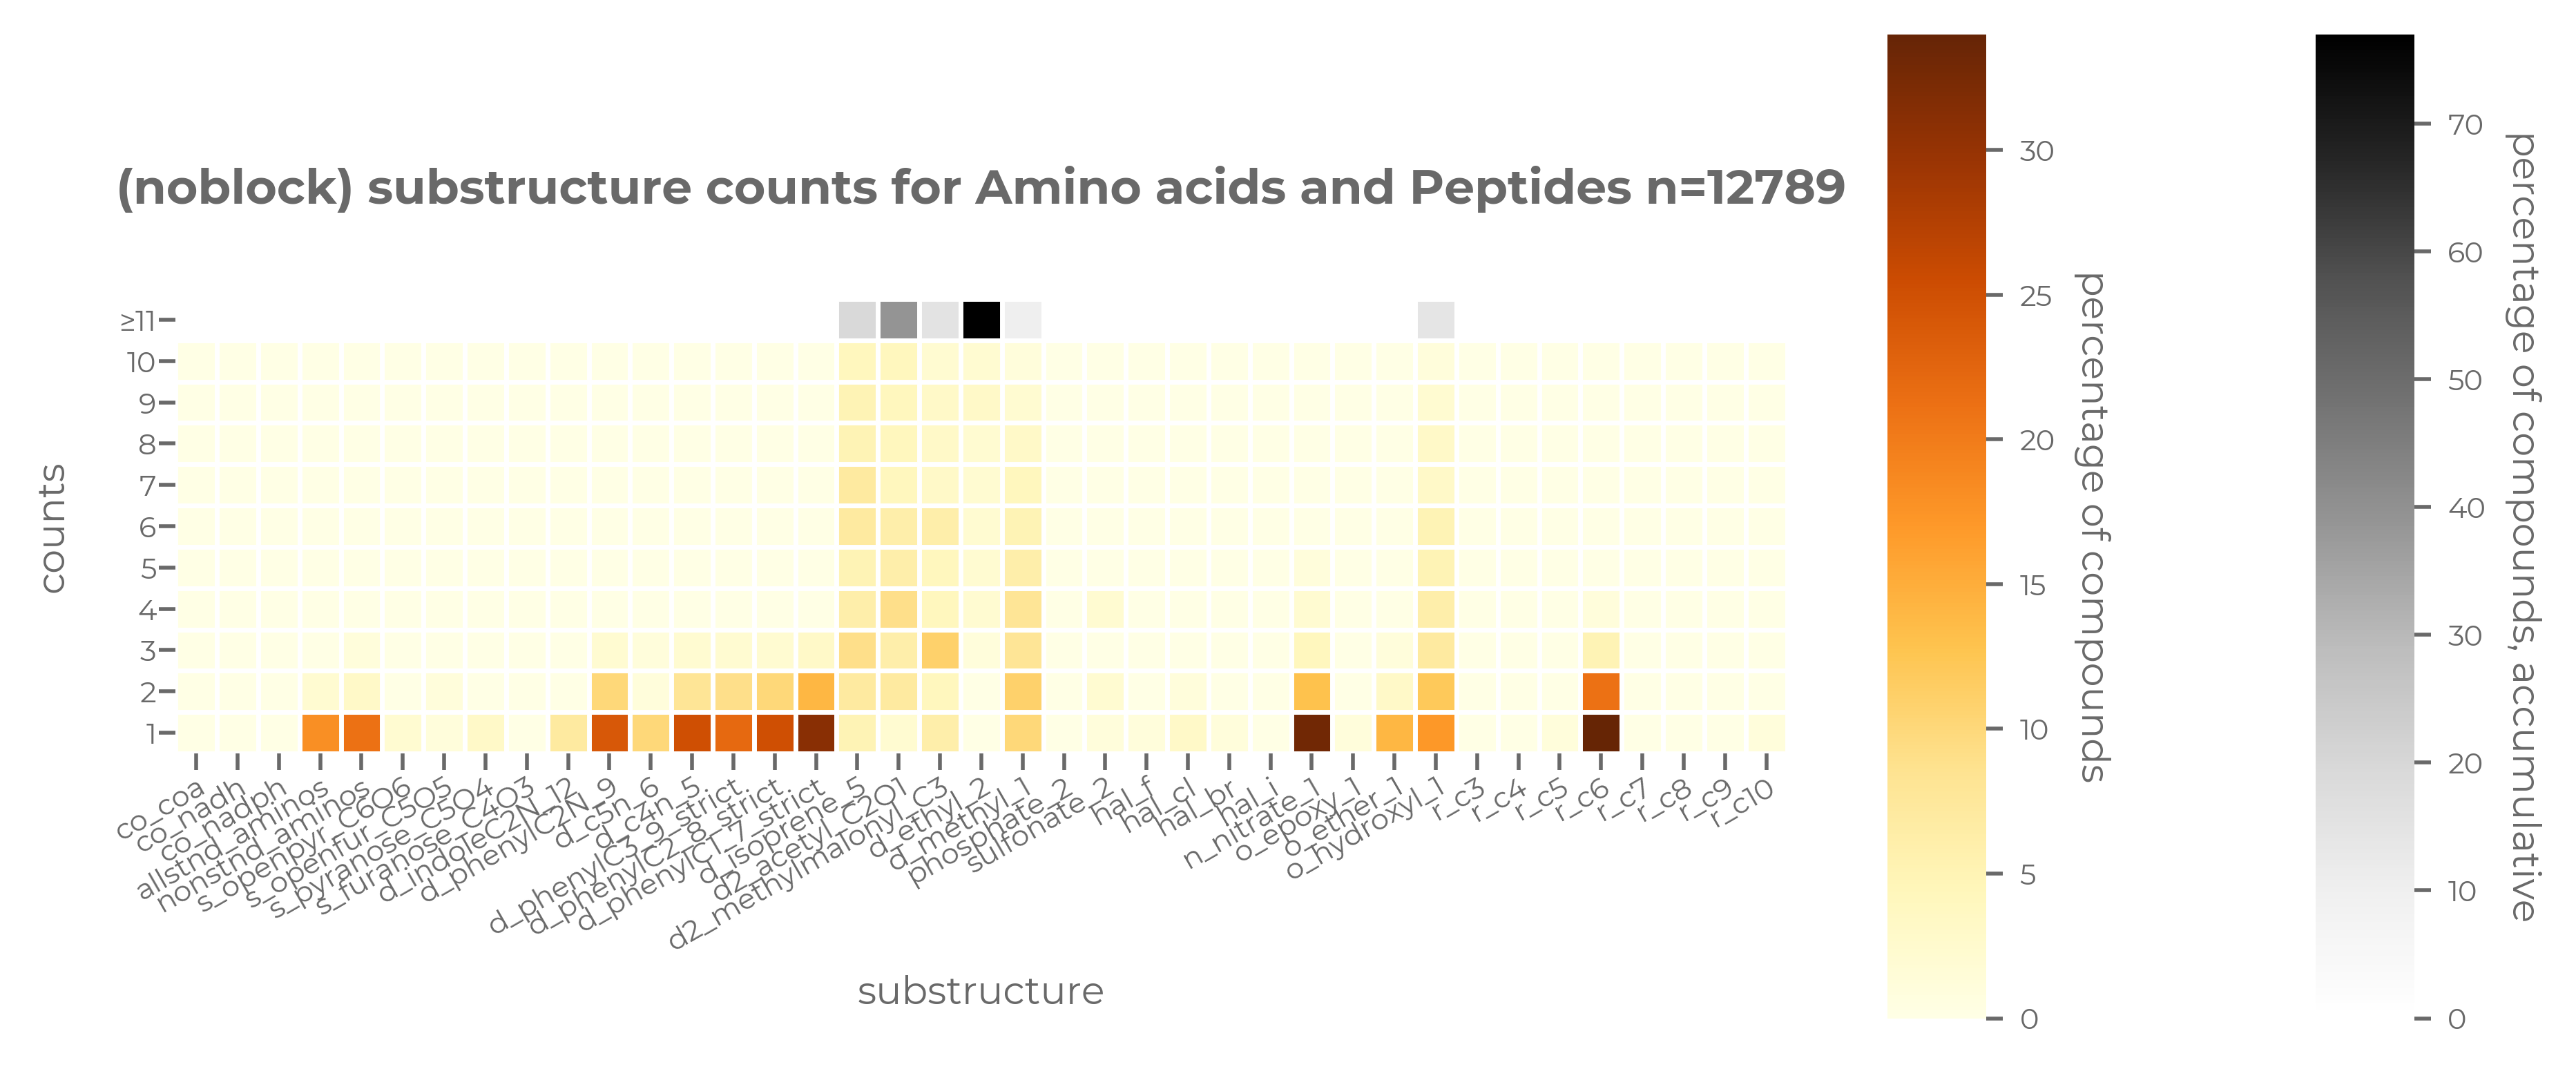

In [99]:
colours = {
    "Alkaloids": "Blues",
    "Amino acids and Peptides": "YlOrBr",
    "Carbohydrates": "RdPu",
    "Fatty acids": "Oranges",
    "Polyketides": "Reds",
    "Shikimates and Phenylpropanoids": "Purples",
    "Terpenoids": "Greens",
    "None": "Greys",
}
for classif in unique_pathways[0].unique():
    focus = unique_pathways[unique_pathways[0] == classif]
    if not classif:
        classif = "None"
    percentages = True
    annotate = False
    array = np.array(focus["biosynfoni"].tolist())

    # counts = heatmap_array(array, max_height=11, percentages=percentages, accumulative=False, end_accumulative=True)
    under_10, over_10 = over_under_divide(array, limit=10)

    fp_heatmap(
        # heatmap_array(array, max_height=10, percentages=percentages, accumulative=False),
        under_10,
        classif,
        subsnames=substructure_names,
        bsfname=bsf_name,
        size=(8, 6),
        percentages=percentages,
        annotate=annotate,
        scheme=colours[classif],
        title=f"({block_state.strip('_')}) substructure counts for {classif} n={len(focus)}",
        top_acc_array=over_10,  # top accumulative array)
    )

In [120]:
def main():
    print("hello")
    fingerprintfile_coco = argv[1]  # natural products
    fingerprintfile_zinc = argv[2]  # synthetic compounds
    coco = np.loadtxt(fingerprintfile_coco, dtype=int, delimiter=",")
    zinc = np.loadtxt(fingerprintfile_zinc, dtype=int, delimiter=",")
    coco_name = fingerprintfile_coco.split("/")[-1].split(".")[0]
    zinc_name = fingerprintfile_zinc.split("/")[-1].split(".")[0]
    # bsf_name_coco = coco_name.replace("_noblock", '').replace(split("_")[-1]
    if len(argv) > 3:
        bsf_name = argv[3]
    if fpVersions[bsf_name]:
        substructure_names = fpVersions[bsf_name]

    coco_mean = fp_stats(coco, coco_name)
    zinc_mean = fp_stats(zinc, zinc_name)
    # fp_plots(coco, coco_name)
    # fp_plots(zinc, zinc_name)
    fp_heatmap(
        heatmap_array(coco, max_height=30),
        coco_name,
        subsnames=substructure_names,
        bsfname=bsf_name,
    )
    fp_heatmap(
        heatmap_array(zinc, max_height=30),
        zinc_name,
        subsnames=substructure_names,
        bsfname=bsf_name,
    )

    fp_means_plots(coco_mean, zinc_mean, outfile_namer(f"{coco_name}_{zinc_name}.svg"))

([<matplotlib.collections.PolyCollection at 0x14660c510>,
 <matplotlib.colorbar.Colorbar at 0x1462f94d0>)

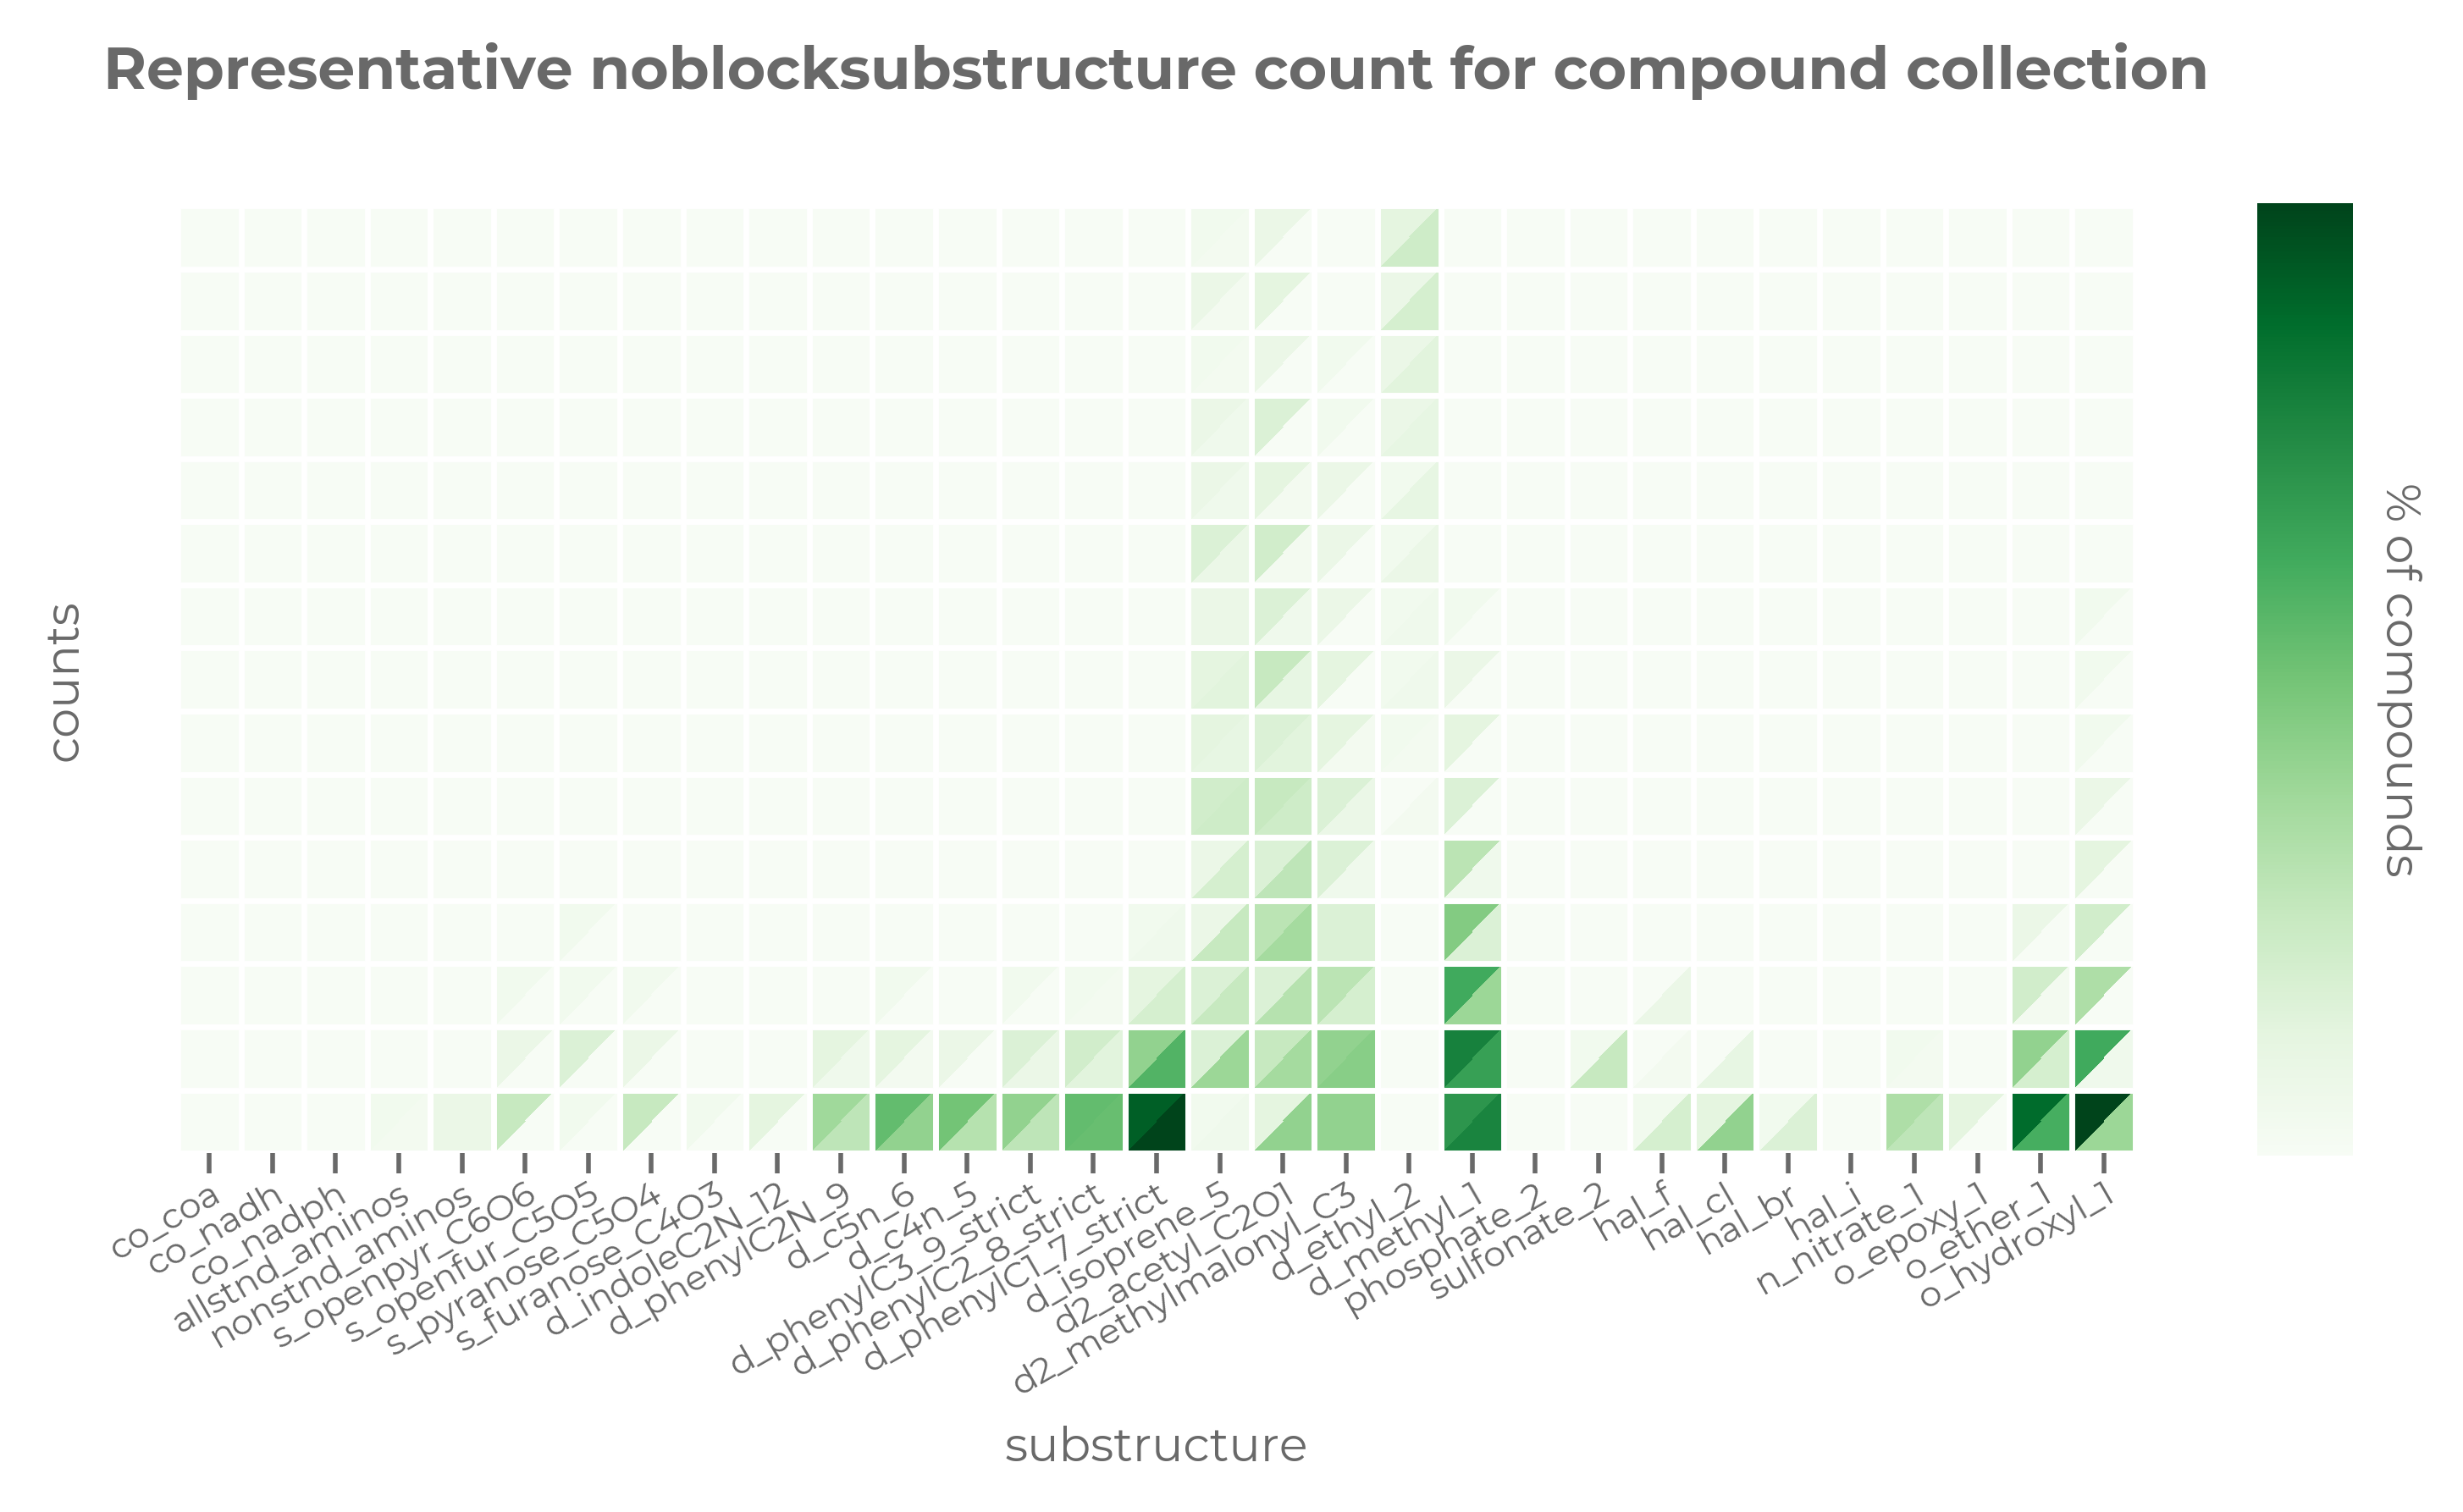

In [92]:
from matplotlib.tri import Triangulation
from matplotlib.colors import LinearSegmentedColormap, ListedColormap


# with triangles
percentages = True
annotate = False
relay_subs = False if bsf_name == "leaf" else True
width = 50 if bsf_name == "leaf" else 10


def triangulation_for_triheatmap(M, N):
    xv, yv = np.meshgrid(
        np.arange(-0.5, M), np.arange(-0.5, N)
    )  # vertices of the little squares
    xc, yc = np.meshgrid(
        np.arange(0, M), np.arange(0, N)
    )  # centers of the little squares
    x = np.concatenate([xv.ravel(), xc.ravel()])
    y = np.concatenate([yv.ravel(), yc.ravel()])
    cstart = (M + 1) * (N + 1)  # indices of the centers

    trianglesN = [
        (i + j * (M + 1), i + 1 + j * (M + 1), cstart + i + j * M)
        for j in range(N)
        for i in range(M)
    ]
    trianglesE = [
        (i + 1 + j * (M + 1), i + 1 + (j + 1) * (M + 1), cstart + i + j * M)
        for j in range(N)
        for i in range(M)
    ]
    trianglesS = [
        (i + 1 + (j + 1) * (M + 1), i + (j + 1) * (M + 1), cstart + i + j * M)
        for j in range(N)
        for i in range(M)
    ]
    trianglesW = [
        (i + (j + 1) * (M + 1), i + j * (M + 1), cstart + i + j * M)
        for j in range(N)
        for i in range(M)
    ]
    return [
        Triangulation(x, y, triangles)
        for triangles in [trianglesN, trianglesE, trianglesS, trianglesW]
    ]


def triheatmap(
    data1: np.array,
    data2: np.array,
    row_labels: list,
    col_labels: list,
    ax=None,
):
    values = [data1, data2, data2, data1]
    triangul = triangulation_for_triheatmap(coco_ha.shape[1], coco_ha.shape[0])
    cmaps = ["Greens", "Purples", "Purples", "Greens"]
    # norms = [plt.Normalize(-0.5, 1) for _ in range(4)]
    fig, ax = plt.subplots()
    # imgs = [ax.tripcolor(t, np.ravel(val), cmap=cmap, norm=norm, ec='white')
    #        for t, val, cmap, norm in zip(triangul, values, cmaps, norms)]
    imgs = [
        ax.tripcolor(t, np.ravel(val), cmap=cmap)
        for t, val, cmap in zip(triangul, values, cmaps)
    ]

    ax.invert_yaxis()
    ax.margins(x=0, y=0)
    ax.set_aspect("equal", "box")  # square cells
    plt.tight_layout()
    plt.show()
    return None


def triheatmap(
    data1: np.array,
    data2: np.array,
    row_labels: list = [],
    col_labels: list = [],
    ax=None,
    cbar_kw=None,
    cbarlabel1="% of natural products",
    cbarlabel2="% of compounds",
    title="Substructure counts for natural products vs synthetic compounds",
    colours=("Greens", "Purples"),
    normalise=False,
    **kwargs,
):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    values = [data1, data2, data2, data1]
    triangul = triangulation_for_triheatmap(coco_ha.shape[1], coco_ha.shape[0])
    cmaps = [colours[0], colours[1], colours[1], colours[0]]
    # Plot the heatmap
    # im = ax.imshow(data, **kwargs)
    if normalise:
        norms = [plt.Normalize(0, 100) for _ in range(4)]
        imgs = [
            ax.tripcolor(t, np.ravel(val), cmap=cmap, norm=norm)
            for t, val, cmap, norm in zip(triangul, values, cmaps, norms)
        ]
    else:
        imgs = [
            ax.tripcolor(t, np.ravel(val), cmap=cmap)
            for t, val, cmap in zip(triangul, values, cmaps)
        ]

    # Create colorbar
    cbar = ax.figure.colorbar(imgs[1], ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel2, rotation=-90, va="bottom")
    cbar.ax.set_yticks([])
    cbar.outline.set_visible(False)
    # cbar2 = ax.figure.colorbar(imgs[3], ax=ax, **cbar_kw) #cbar 2 is left
    # cbar2.ax.set_ylabel(cbarlabel1, rotation=-90, va="bottom")
    # cbar2.ax.set_yticks([])
    # cbar2.outline.set_visible(False)
    # cbar3 = ax.figure.colorbar(imgs[2], ax=ax, **cbar_kw)
    # cbar3.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data1.shape[1]), labels=col_labels, size=6)
    # ax.set_yticks(np.arange(data.shape[0]), labels=row_labels, size = 6)
    ax.set_yticks([])

    # Let the horizontal axes labeling appear on bottom (default)
    ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)
    ax.tick_params(pad=0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.invert_yaxis()
    ax.margins(x=0, y=0)
    ax.set_xticks(np.arange(data1.shape[1] + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(data1.shape[0] + 1) - 0.5, minor=True)
    ax.set_aspect("equal", "box")  # square cells

    ax.grid(which="minor", color="w", linestyle="-", linewidth=1, alpha=1.0)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_xlabel("substructure")
    ax.set_ylabel("counts", labelpad=10)
    ax.set_title(title, loc="center", pad=20)
    plt.tight_layout()
    plt.savefig(f"{outfile_namer('triheatmap', bsf_name)}{block_state}_heatmap.png")

    return imgs, cbar


coco_ha = heatmap_array(coco, max_height=15, percentages=True, accumulative=False)
zinc_ha = heatmap_array(zinc, max_height=15, percentages=True, accumulative=False)

top = mpl.colormaps["Greys"].resampled(128)
middle = mpl.colormaps["Greys"].resampled(128)
bottom = mpl.colormaps["Greens"].resampled(128)

newcolors = np.vstack((top(np.linspace(0, 0.4, 128)), bottom(np.linspace(0.3, 1, 128))))
newcmp = ListedColormap(newcolors, name="GreenGrey")
# mpl.colormaps.register(cmap=my_cmap)
# plot_examples([viridis, newcmp])


subsnames = [x for x in substructure_names]
triheatmap(
    coco_ha,
    zinc_ha,
    col_labels=subsnames,
    cbar_kw={"shrink": 0.5, "pad": 0.05, "aspect": 10},
    title=f"Representative {block_state.strip('_')}substructure count for compound collection",
    # colours = ("Greys", "Greys"),
    # colours = (newcmp,newcmp)
    colours=("Greens", "Greens"),
)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# statistics

### count distributions

# mol draw

In [ ]:
a = """co_coa	SCCN~C(~O)CCN~C(~O)C(C(C)(C)COP(O)(~O)OP(~O)(O)OCC1C(C(C(O1)[#7]2~[#6]~[#7]~[#6]~3~[#6](~[#7]~[#6]~[#7]~[#6]~3~2)~[#7])O)OP(~O)(O)O)~O
co_nadh	C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(O)OCC3C(C(C(O3)N4C=NC5=C(N=CN=C54)N)O)O)O)O
co_nadph	C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(O)OCC3C(C(C(O3)N4C=NC5=C(N=CN=C54)N)OP(=O)(O)O)O)O)O
allstnd_aminos	[$([$([NX3H,NX4H2+]),$([NX3](C)(C)(C))]1[CX4H]([CH2][CH2][CH2]1)[CX3](=[OX1])[OX2H,OX1-,N]),$([$([NX3H2,NX4H3+]),$([NX3H](C)(C))][CX4H2][CX3](=[OX1])[OX2H,OX1-,N]),$([$([NX3H2,NX4H3+]),$([NX3H](C)(C))][CX4H]([*])[CX3](=[OX1])[OX2H,OX1-,N])]
nonstnd_aminos	[$([NX3,NX4+][CX4H]([*])[CX3](=[OX1])[O,N]);!$([$([$([NX3H,NX4H2+]),$([NX3](C)(C)(C))]1[CX4H]([CH2][CH2][CH2]1)[CX3](=[OX1])[OX2H,OX1-,N]),$([$([NX3H2,NX4H3+]),$([NX3H](C)(C))][CX4H2][CX3](=[OX1])[OX2H,OX1-,N]),$([$([NX3H2,NX4H3+]),$([NX3H](C)(C))][CX4H]([$([CH3X4]),$([CH2X4][CH2X4][CH2X4][NHX3][CH0X3](=[NH2X3+,NHX2+0])[NH2X3]),$([CH2X4][CX3](=[OX1])[NX3H2]),$([CH2X4][CX3](=[OX1])[OH0-,OH]),$([CH2X4][SX2H,SX1H0-]),$([CH2X4][CH2X4][CX3](=[OX1])[OH0-,OH]),$([CH2X4][#6X3]1:[$([#7X3H+,#7X2H0+0]:[#6X3H]:[#7X3H]),$([#7X3H])]:[#6X3H]:[$([#7X3H+,#7X2H0+0]:[#6X3H]:[#7X3H]),$([#7X3H])]:[#6X3H]1),$([CHX4]([CH3X4])[CH2X4][CH3X4]),$([CH2X4][CHX4]([CH3X4])[CH3X4]),$([CH2X4][CH2X4][CH2X4][CH2X4][NX4+,NX3+0]),$([CH2X4][CH2X4][SX2][CH3X4]),$([CH2X4][cX3]1[cX3H][cX3H][cX3H][cX3H][cX3H]1),$([CH2X4][OX2H]),$([CHX4]([CH3X4])[OX2H]),$([CH2X4][cX3]1[cX3H][nX3H][cX3]2[cX3H][cX3H][cX3H][cX3H][cX3]12),$([CH2X4][cX3]1[cX3H][cX3H][cX3]([OHX2,OH0X1-])[cX3H][cX3H]1),$([CHX4]([CH3X4])[CH3X4])])[CX3](=[OX1])[OX2H,OX1-,N])])]
s_openpyr_C6O6	C(~[#8])~C(~[#8])~C(~[#8])~C(~[#8])~C(~[#8])~C(~[#8])
s_openfur_C5O5	C(~[#8])~C(~[#8])~C(~[#8])~C(~[#8])~C(~[#8])
s_pyranose_C5O4	C~1~[#8]~C~C(~[#8])~C(~[#8])~C(~[#8])~1
s_furanose_C4O3	C~1~[#8]~C~C(~[#8])~C(~[#8])~1
d_indoleC2N_12	c1cccc2c1c(~[#6]~[#6]~[#7])cn2
d_phenylC2N_9	c1ccccc1[#6][#6][#7]
d_c5n_6	[#6]~1~[#6]~[#6]~[#6]~[#6]~[#7]~1
d_c4n_5	[#6]~1~[#6]~[#6]~[#6]~[#7]~1
d_phenylC3_9_strict	[#6;R1]~1~[#6;R1]~[#6;R1]~[#6;R1]~[#6;R1]~[#6;R1]~1~[#6]~[#6;!$([r6])]~[#6;!$([r6])]
d_phenylC2_8_strict	[#6;R1]~1~[#6;R1]~[#6;R1]~[#6;R1]~[#6;R1]~[#6;R1]~1~[#6]~[#6;!$([r6])]
d_phenylC1_7_strict	[#6;R1]~1~[#6;R1]~[#6;R1]~[#6;R1]~[#6;R1]~[#6;R1]~1~[#6]
d_isoprene_5	[#6]~[#6](~[#6])~[#6]~[#6]
d2_acetyl_C2O1	[#6]~[#6]~[#8]
d2_methylmalonyl_C3	[#6]~[#6][C;D1;h3]
d_ethyl_2	[#6]~[#6]
d_methyl_1	[C;D1;h3]
phosphate_2	P~O
sulfonate_2	S~O
hal_f	[#9]
hal_cl	[#17]
hal_br	[#35]
hal_i	[#53]
n_nitrate_1	[N;D1]
o_epoxy_1	[O;x2;r3]
o_ether_1	[O;D2;!h;!$(*C=O);X2;!R;!$(*P);!$(*S)]
o_hydroxyl_1	[#8;D1;h,!v2;$(*[#6,#7]);!$(*C~O);!$(P);!$(S)]
"""

subs2draw = a.split("\n")
subs2draw = subs2draw[3:]
subs2draw = [(x.split("\t")[0], x.split("\t")[1]) for x in subs2draw if x]


from rdkit import Chem
from rdkit.Chem import Draw
from math import floor, sqrt


def draw_smarts(smarts_list, labels=None):
    """
    Draw a list of molecules specified by SMARTS patterns side by side in a single image.

    Args:
    - smarts_list (list): A list of SMARTS patterns
    - labels (list): A list of labels for each molecule

    Returns:
    - PIL.Image: A single image with all the molecules drawn side by side
    """
    mol_list = [Chem.MolFromSmarts(s) for s in smarts_list]
    img = Draw.MolsToGridImage(
        mol_list,
        molsPerRow=floor(sqrt(len(smarts_list))),
        subImgSize=(200, 200),
        legends=labels,
        useSVG=True,
    )

    return img


img = draw_smarts([x[1] for x in subs2draw], labels=[x[0] for x in subs2draw])
# img.save(f"{bsf_name_root}.png", format="PNG", dpi=300)
img

In [137]:
rdk = np.loadtxt("../thesis/0814_rdk_sdf_ids_props.csv", delimiter=",", dtype=str)

In [181]:
suppl = Chem.SDMolSupplier("../thesis/input/COCONUT_DB_rdk_props.sdf")
len(suppl)

293957